# Bird Call Feature Extraction and Analysis Using Signal Processing

## Introduction

This project aims to explore signal processing techniques to analyze bird calls, focusing on extracting relevant features from audio recordings. 
### Objectives
1. **Signal Importation**:
   - Use a bird sound database (Xeno-canto API) to obtain diverse recordings.
2. **Signal Processing**:
   - Apply noise reduction and normalization techniques to improve data quality.
   - Extract temporal and frequency domain features using libraries such as `librosa` and Fourier transforms.
3. **Unsupervised Learning**:
   - Use algorithms like K-Means to categorize sounds based on extracted features.

### Significance
The analysis of bird calls has applications in various fields, such as ecology, environmental monitoring, and biodiversity conservation. This project provides a solid foundation for more in-depth studies, presenting a practical and data-driven approach.

In this notebook, you will find a complete workflow from data acquisition to cluster analysis, highlighting the use of modern signal processing.

## Library Imports
These libraries enable tasks such as data retrieval, preprocessing, visualization, feature extraction, and clustering.

In [2]:
import requests
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr  # Noise reduction library
import soundfile as sf    # For saving the noise-reduced audio files
from scipy.signal import butter, lfilter
from scipy.fftpack import fft
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Define the API endpoint and query
base_url = "https://www.xeno-canto.org/api/2/recordings"
birds = ["penguin", "Red-tailed Hawk", "Greater Prairie Chicken", "Magpie Goose"]


/opt/homebrew/Caskroom/miniconda/base/envs/FCED/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Acquisition

### Retrieving Bird Call Recordings
The data acquisition process involves fetching bird call recordings from the Xeno-canto API. This database provides extensive audio samples for various bird species, making it a reliable source for our analysis. 

### Selected Bird Species
The analysis focuses on the following species:
- **Penguin**
- **Red-tailed Hawk**
- **Greater Prairie Chicken**
- **Magpie Goose**

These species were chosen for their diverse habitats and vocalization patterns, which provide a varied dataset for clustering and signal processing tasks.

In [206]:
# Dictionary to store DataFrames for each bird
df_birds = {}

In [207]:
query = birds[0]  # Search for the current bird
url = f"{base_url}?query={query}"

# Initialize variables
recordings = []
page = 1

# Fetch data until we have at least 30 recordings
while len(recordings) < 30:
    # Fetch data from the API with pagination
    response = requests.get(f"{url}&page={page}")
    if response.status_code == 200:
        data = response.json()
        # Append recordings to the list
        recordings.extend(data.get("recordings", []))
        # If there are no more recordings, stop
        if len(data.get("recordings", [])) == 0:
            break
        page += 1
    else:
        print(f"Error: Unable to fetch data for {birds[0]}. Status code {response.status_code}")
        break

# Limit the list to 20 recordings
recordings = recordings[:30]

# Create a DataFrame for the current bird and store it in the dictionary
df_birds[birds[0]] = pd.DataFrame(recordings)

# Display the DataFrame for the current bird
if not df_birds[birds[0]].empty:
    print(f"Data for {birds[0]}:")
    print(df_birds[birds[0]][["gen", "sp", "en", "loc", "file"]])
else:
    print(f"No data found for {birds[0]}.")

Data for penguin:
            gen           sp            en  \
0   Aptenodytes  patagonicus  King Penguin   
1   Aptenodytes  patagonicus  King Penguin   
2   Aptenodytes  patagonicus  King Penguin   
3   Aptenodytes  patagonicus  King Penguin   
4   Aptenodytes  patagonicus  King Penguin   
5   Aptenodytes  patagonicus  King Penguin   
6   Aptenodytes  patagonicus  King Penguin   
7   Aptenodytes  patagonicus  King Penguin   
8   Aptenodytes  patagonicus  King Penguin   
9   Aptenodytes  patagonicus  King Penguin   
10  Aptenodytes  patagonicus  King Penguin   
11  Aptenodytes  patagonicus  King Penguin   
12  Aptenodytes  patagonicus  King Penguin   
13  Aptenodytes  patagonicus  King Penguin   
14  Aptenodytes  patagonicus  King Penguin   
15  Aptenodytes  patagonicus  King Penguin   
16  Aptenodytes  patagonicus  King Penguin   
17  Aptenodytes  patagonicus  King Penguin   
18  Aptenodytes  patagonicus  King Penguin   
19  Aptenodytes  patagonicus  King Penguin   
20  Aptenodytes 

In [208]:
query = birds[1]  # Search for the current bird
url = f"{base_url}?query={query}"

# Initialize variables
recordings = []
page = 1

# Fetch data until we have at least 20 recordings
while len(recordings) < 30:
    # Fetch data from the API with pagination
    response = requests.get(f"{url}&page={page}")
    if response.status_code == 200:
        data = response.json()
        # Append recordings to the list
        recordings.extend(data.get("recordings", []))
        # If there are no more recordings, stop
        if len(data.get("recordings", [])) == 0:
            break
        page += 1
    else:
        print(f"Error: Unable to fetch data for {birds[1]}. Status code {response.status_code}")
        break

# Limit the list to 20 recordings
recordings = recordings[:30]

# Create a DataFrame for the current bird and store it in the dictionary
df_birds[birds[1]] = pd.DataFrame(recordings)

# Display the DataFrame for the current bird
if not df_birds[birds[1]].empty:
    print(f"Data for {birds[1]}:")
    print(df_birds[birds[1]][["gen", "sp", "en", "loc", "file"]])
else:
    print(f"No data found for {birds[1]}.")

Data for Red-tailed Hawk:
      gen           sp               en  \
0   Buteo  jamaicensis  Red-tailed Hawk   
1   Buteo  jamaicensis  Red-tailed Hawk   
2   Buteo  jamaicensis  Red-tailed Hawk   
3   Buteo  jamaicensis  Red-tailed Hawk   
4   Buteo  jamaicensis  Red-tailed Hawk   
5   Buteo  jamaicensis  Red-tailed Hawk   
6   Buteo  jamaicensis  Red-tailed Hawk   
7   Buteo  jamaicensis  Red-tailed Hawk   
8   Buteo  jamaicensis  Red-tailed Hawk   
9   Buteo  jamaicensis  Red-tailed Hawk   
10  Buteo  jamaicensis  Red-tailed Hawk   
11  Buteo  jamaicensis  Red-tailed Hawk   
12  Buteo  jamaicensis  Red-tailed Hawk   
13  Buteo  jamaicensis  Red-tailed Hawk   
14  Buteo  jamaicensis  Red-tailed Hawk   
15  Buteo  jamaicensis  Red-tailed Hawk   
16  Buteo  jamaicensis  Red-tailed Hawk   
17  Buteo  jamaicensis  Red-tailed Hawk   
18  Buteo  jamaicensis  Red-tailed Hawk   
19  Buteo  jamaicensis  Red-tailed Hawk   
20  Buteo  jamaicensis  Red-tailed Hawk   
21  Buteo  jamaicensis  Red-

In [209]:
query = birds[2]  # Search for the current bird
url = f"{base_url}?query={query}"

# Initialize variables
recordings = []
page = 1

# Fetch data until we have at least 20 recordings
while len(recordings) < 30:
    # Fetch data from the API with pagination
    response = requests.get(f"{url}&page={page}")
    if response.status_code == 200:
        data = response.json()
        # Append recordings to the list
        recordings.extend(data.get("recordings", []))
        # If there are no more recordings, stop
        if len(data.get("recordings", [])) == 0:
            break
        page += 1
    else:
        print(f"Error: Unable to fetch data for {birds[2]}. Status code {response.status_code}")
        break

# Limit the list to 20 recordings
recordings = recordings[:30]

# Create a DataFrame for the current bird and store it in the dictionary
df_birds[birds[2]] = pd.DataFrame(recordings)

# Display the DataFrame for the current bird
if not df_birds[birds[2]].empty:
    print(f"Data for {birds[2]}:")
    print(df_birds[birds[2]][["gen", "sp", "en", "loc", "file"]])
else:
    print(f"No data found for {birds[2]}.")

Data for Greater Prairie Chicken:
            gen      sp                       en  \
0   Tympanuchus  cupido  Greater Prairie Chicken   
1   Tympanuchus  cupido  Greater Prairie Chicken   
2   Tympanuchus  cupido  Greater Prairie Chicken   
3   Tympanuchus  cupido  Greater Prairie Chicken   
4   Tympanuchus  cupido  Greater Prairie Chicken   
5   Tympanuchus  cupido  Greater Prairie Chicken   
6   Tympanuchus  cupido  Greater Prairie Chicken   
7   Tympanuchus  cupido  Greater Prairie Chicken   
8   Tympanuchus  cupido  Greater Prairie Chicken   
9   Tympanuchus  cupido  Greater Prairie Chicken   
10  Tympanuchus  cupido  Greater Prairie Chicken   
11  Tympanuchus  cupido  Greater Prairie Chicken   
12  Tympanuchus  cupido  Greater Prairie Chicken   
13  Tympanuchus  cupido  Greater Prairie Chicken   
14  Tympanuchus  cupido  Greater Prairie Chicken   
15  Tympanuchus  cupido  Greater Prairie Chicken   
16  Tympanuchus  cupido  Greater Prairie Chicken   
17  Tympanuchus  cupido  Great

In [210]:
query = birds[3]  # Search for the current bird
url = f"{base_url}?query={query}"

# Initialize variables
recordings = []
page = 1

# Fetch data until we have at least 20 recordings
while len(recordings) < 30:
    # Fetch data from the API with pagination
    response = requests.get(f"{url}&page={page}")
    if response.status_code == 200:
        data = response.json()
        # Append recordings to the list
        recordings.extend(data.get("recordings", []))
        # If there are no more recordings, stop
        if len(data.get("recordings", [])) == 0:
            break
        page += 1
    else:
        print(f"Error: Unable to fetch data for {birds[3]}. Status code {response.status_code}")
        break

# Limit the list to 20 recordings
recordings = recordings[:30]

# Create a DataFrame for the current bird and store it in the dictionary
df_birds[birds[3]] = pd.DataFrame(recordings)

# Display the DataFrame for the current bird
if not df_birds[birds[3]].empty:
    print(f"Data for {birds[3]}:")
    print(df_birds[birds[3]][["gen", "sp", "en", "loc", "file"]])
else:
    print(f"No data found for {birds[3]}.")

Error: Unable to fetch data for Magpie Goose. Status code 400
Data for Magpie Goose:
          gen           sp            en  \
0   Anseranas  semipalmata  Magpie Goose   
1   Anseranas  semipalmata  Magpie Goose   
2   Anseranas  semipalmata  Magpie Goose   
3   Anseranas  semipalmata  Magpie Goose   
4   Anseranas  semipalmata  Magpie Goose   
5   Anseranas  semipalmata  Magpie Goose   
6   Anseranas  semipalmata  Magpie Goose   
7   Anseranas  semipalmata  Magpie Goose   
8   Anseranas  semipalmata  Magpie Goose   
9   Anseranas  semipalmata  Magpie Goose   
10  Anseranas  semipalmata  Magpie Goose   
11  Anseranas  semipalmata  Magpie Goose   
12  Anseranas  semipalmata  Magpie Goose   
13  Anseranas  semipalmata  Magpie Goose   
14  Anseranas  semipalmata  Magpie Goose   
15  Anseranas  semipalmata  Magpie Goose   
16  Anseranas  semipalmata  Magpie Goose   
17  Anseranas  semipalmata  Magpie Goose   
18  Anseranas  semipalmata  Magpie Goose   
19  Anseranas  semipalmata  Magpie 

Creates the directories where we store the birds call without preprocessing it.

In [211]:
# Iterate through the bird dictionary
for bird, df in df_birds.items():
    # Skip if the DataFrame is empty
    if df.empty:
        print(f"No recordings found for {bird}.")
        continue
    
    # Create a folder for the bird
    folder_name = f"{bird}_sounds"
    os.makedirs(folder_name, exist_ok=True)  # Ensure the directory exists

    # Download each recording
    recordings = df.to_dict('records')  # Convert DataFrame to a list of dictionaries
    for i, recording in enumerate(recordings):
        audio_url = recording['file']  # Use the URL directly
        species = recording.get('en', "unknown_species")  # Handle missing English names
        file_name = f"{folder_name}/{species.replace(' ', '_')}_{i+1}.mp3"
        try:
            audio_response = requests.get(audio_url)
            if audio_response.status_code == 200:  # Ensure the response is valid
                with open(file_name, 'wb') as f:
                    f.write(audio_response.content)
                print(f"Downloaded: {file_name}")
            else:
                print(f"Failed to download {audio_url}: HTTP {audio_response.status_code}")
        except Exception as e:
            print(f"Failed to download {audio_url}: {e}")


Downloaded: penguin_sounds/King_Penguin_1.mp3
Downloaded: penguin_sounds/King_Penguin_2.mp3
Downloaded: penguin_sounds/King_Penguin_3.mp3
Downloaded: penguin_sounds/King_Penguin_4.mp3
Downloaded: penguin_sounds/King_Penguin_5.mp3
Downloaded: penguin_sounds/King_Penguin_6.mp3
Downloaded: penguin_sounds/King_Penguin_7.mp3
Downloaded: penguin_sounds/King_Penguin_8.mp3
Downloaded: penguin_sounds/King_Penguin_9.mp3
Downloaded: penguin_sounds/King_Penguin_10.mp3
Downloaded: penguin_sounds/King_Penguin_11.mp3
Downloaded: penguin_sounds/King_Penguin_12.mp3
Downloaded: penguin_sounds/King_Penguin_13.mp3
Downloaded: penguin_sounds/King_Penguin_14.mp3
Downloaded: penguin_sounds/King_Penguin_15.mp3
Downloaded: penguin_sounds/King_Penguin_16.mp3
Downloaded: penguin_sounds/King_Penguin_17.mp3
Downloaded: penguin_sounds/King_Penguin_18.mp3
Downloaded: penguin_sounds/King_Penguin_19.mp3
Downloaded: penguin_sounds/King_Penguin_20.mp3
Downloaded: penguin_sounds/King_Penguin_21.mp3
Downloaded: penguin_so

# 2. Preprocessing
## 2.1 Noise Reduction

### Purpose of Noise Reduction
Noise reduction is a crucial preprocessing step in signal processing, especially for audio signals. Environmental noise and recording artifacts can significantly degrade the quality of bird call recordings, leading to inaccurate feature extraction and poor performance in downstream tasks such as clustering or classification. By applying noise reduction, we can:

- Enhance the clarity of the bird calls.
- Improve the accuracy of extracted features (e.g., spectral and temporal characteristics).
- Ensure better clustering or classification results in machine learning tasks.

### Implementation
The function `apply_noise_reduction` automates the process of noise reduction for all `.mp3` files in specified directories. It uses the `noisereduce` library to apply noise suppression and saves the processed audio files in organized output directories.

#### Steps:
1. Iterate through input directories containing raw audio files.
2. For each audio file, load the signal and apply noise reduction using the `noisereduce` library.
3. Save the processed audio signals in dedicated output directories for further analysis.

This preprocessing step ensures that the dataset used for feature extraction and machine learning is of high quality, leading to more reliable insights and conclusions.

In [30]:
# Function to apply noise reduction to all .mp3 files in the given directories
def apply_noise_reduction(input_directories, output_base_dir):
    """
    Applies noise reduction to all .mp3 files in the input directories and saves them to output directories.
    
    Args:
    - input_directories (list): List of directories containing audio files.
    - output_base_dir (str): Directory to save noise-reduced audio files.
    """
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)
    
    for input_dir in input_directories:
        # Define output directory for this input folder
        output_dir = os.path.join(output_base_dir, os.path.basename(input_dir) + "_noise_reduced")
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"\nProcessing directory: {input_dir}")
        print(f"Saving noise-reduced files to: {output_dir}")

        # List all .mp3 files
        audio_files = [f for f in os.listdir(input_dir) if f.endswith(".mp3")]
        
        if not audio_files:
            print(f"No audio files found in {input_dir}.")
            continue

        # Process each audio file
        for audio_file in audio_files:
            input_path = os.path.join(input_dir, audio_file)
            output_path = os.path.join(output_dir, audio_file)

            try:
                # Load the audio file
                y, sr = librosa.load(input_path, sr=None)  # y: audio time series, sr: sampling rate

                # Noise reduction step
                print(f"Applying noise reduction to: {audio_file}")
                reduced_noise = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.5)  # Reduce noise
                
                # Save the noise-reduced audio
                sf.write(output_path, reduced_noise, sr)
                print(f"Saved noise-reduced audio to: {output_path}")
            except Exception as e:
                print(f"Error processing {audio_file}: {e}")

# Input directories
directories = ["penguin_sounds", "Red-tailed Hawk_sounds", "Greater Prairie Chicken_sounds", "Magpie Goose_sounds"]

# Output base directory to save noise-reduced files
output_directory = "noise_reduced_sounds"

# Apply noise reduction
apply_noise_reduction(directories, output_directory)




Processing directory: penguin_sounds
Saving noise-reduced files to: noise_reduced_sounds/penguin_sounds_noise_reduced
Applying noise reduction to: King_Penguin_11.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Penguin_11.mp3
Applying noise reduction to: King_Penguin_10.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Penguin_10.mp3
Applying noise reduction to: King_Penguin_8.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Penguin_8.mp3
Applying noise reduction to: King_Penguin_12.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Penguin_12.mp3
Applying noise reduction to: King_Penguin_13.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Penguin_13.mp3
Applying noise reduction to: King_Penguin_9.mp3
Saved noise-reduced audio to: noise_reduced_sounds/penguin_sounds_noise_reduced/King_Pengu

Applying noise reduction to: Red-tailed_Hawk_11.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_11.mp3
Applying noise reduction to: Red-tailed_Hawk_8.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_8.mp3
Applying noise reduction to: Red-tailed_Hawk_10.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_10.mp3
Applying noise reduction to: Red-tailed_Hawk_12.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_12.mp3
Applying noise reduction to: Red-tailed_Hawk_13.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_13.mp3
Applying noise reduction to: Red-tailed_Hawk_22.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced/Red-tailed_Hawk_22.mp3
Applying noise reduction

Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_23.mp3
Applying noise reduction to: Magpie_Goose_22.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_22.mp3
Applying noise reduction to: Magpie_Goose_20.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_20.mp3
Applying noise reduction to: Magpie_Goose_21.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_21.mp3
Applying noise reduction to: Magpie_Goose_3.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_3.mp3
Applying noise reduction to: Magpie_Goose_2.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_reduced/Magpie_Goose_2.mp3
Applying noise reduction to: Magpie_Goose_1.mp3
Saved noise-reduced audio to: noise_reduced_sounds/Magpie Goose_sounds_noise_redu

Here we have the identification of the temporal centroid and further segmentation of the sound file in 10 second segments. Currently the plot of every seingle sound file is shown and this needs to be reduced 

## 2.2 Temporal Centroid Extraction

### What is a Temporal Centroid?
The temporal centroid represents the "center of mass" of the energy distribution in an audio signal. It is a time point where the cumulative energy of the signal reaches approximately 50% of its total value. This measure helps identify the most significant portion of a sound, which is often the most characteristic part of a bird call.

### Why Use the Temporal Centroid?
In the context of bird call analysis, extracting segments around the temporal centroid offers several benefits:

- **Focus on Meaningful Audio**: The most informative and distinguishing features of a bird call are often concentrated around its temporal centroid.
- **Noise Reduction**: By isolating the central segment of the call, we minimize the impact of irrelevant noise or silence present at the beginning or end of recordings.
- **Feature Enhancement**: Using this technique ensures the extracted features represent the essence of the bird call, improving the accuracy of clustering and classification.

### Implementation
The function `extract_segments_around_temporal_centroid` extracts segments of a user-defined duration centered around the temporal centroid. It also provides visualization of the process for selected audio files.

#### Steps:
1. **Energy Envelope and Cumulative Energy**:
   - Compute the energy envelope of the audio signal.
   - Calculate the cumulative energy to normalize the energy distribution.
2. **Locate Temporal Centroid**:
   - Identify the time index where cumulative energy reaches 50%.
3. **Segment Extraction**:
   - Define a segment around the temporal centroid based on a user-specified duration.
   - Save the extracted segment for further analysis.
4. **Visualization**:
   - For selected files, plot the waveform with the extracted segment highlighted, along with the temporal centroid for better interpretability.

This method ensures that the dataset used for analysis is focused on the most relevant portions of bird calls, enhancing the overall quality of the extracted features.


Processing directory: noise_reduced_sounds/penguin_sounds_noise_reduced
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_11_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_10_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_8_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_12_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_13_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_9_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_17_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_16_segment.wav
Extracted segment saved t

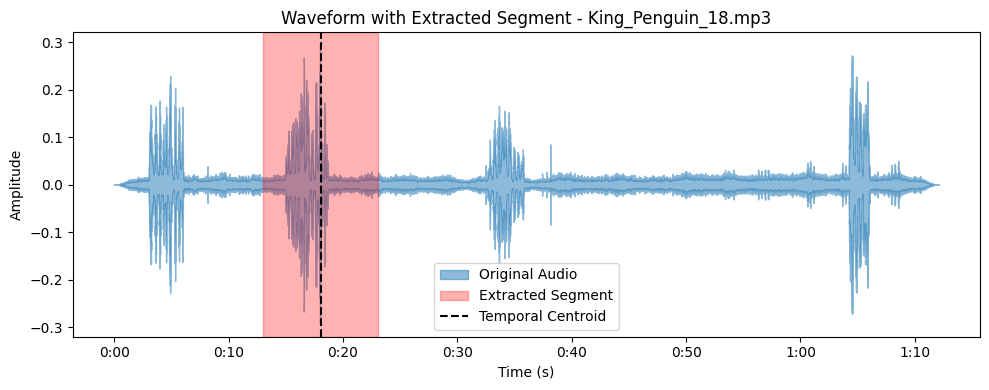

Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_30_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_24_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_25_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_19_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_3_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_1_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_27_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_26_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_

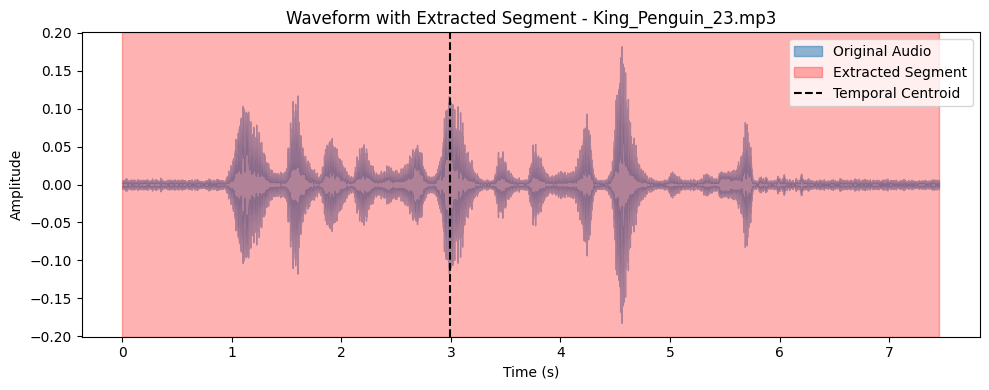

Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_5_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_7_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_21_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_20_segment.wav
Extracted segment saved to: extracted_segments/penguin_sounds_noise_reduced_segments/King_Penguin_6_segment.wav

Processing directory: noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_17_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_16_segment.wav


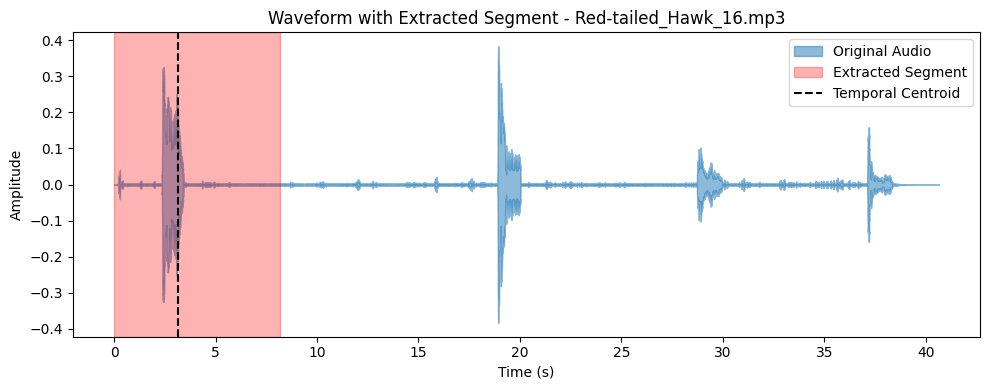

Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_14_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_28_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_29_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_15_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_11_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_8_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_10_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_12_segment.wav


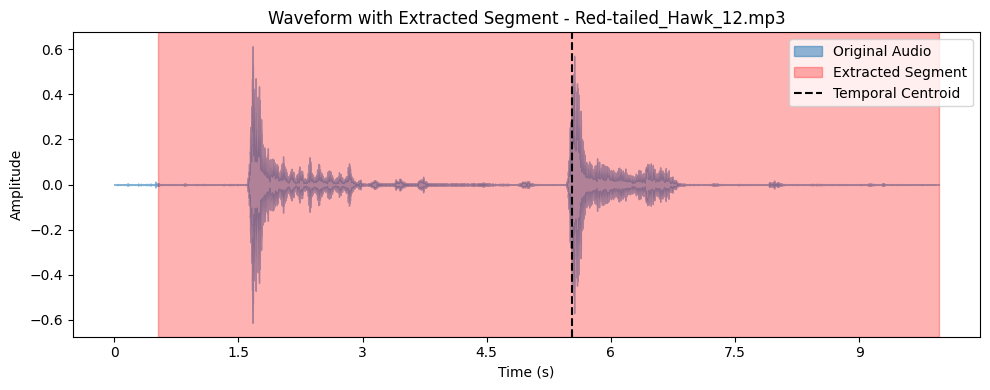

Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_13_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_22_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_6_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_7_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_23_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_21_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_5_segment.wav
Extracted segment saved to: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments/Red-tailed_Hawk_4_segment.wav
Extracted se

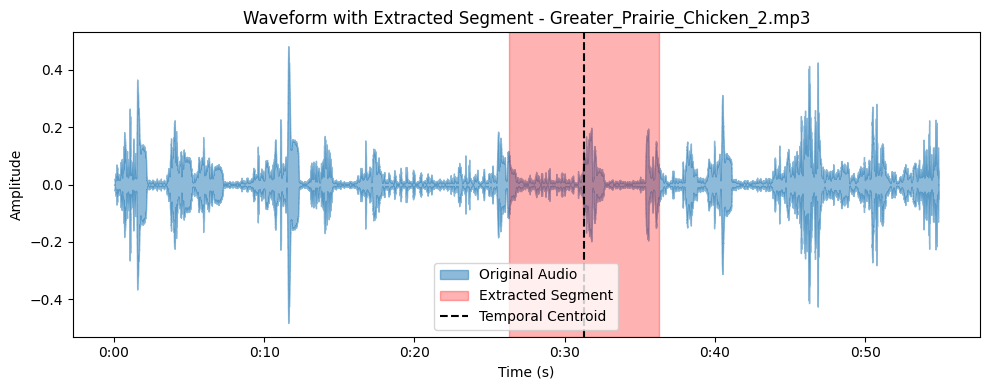

Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_22_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_23_segment.wav


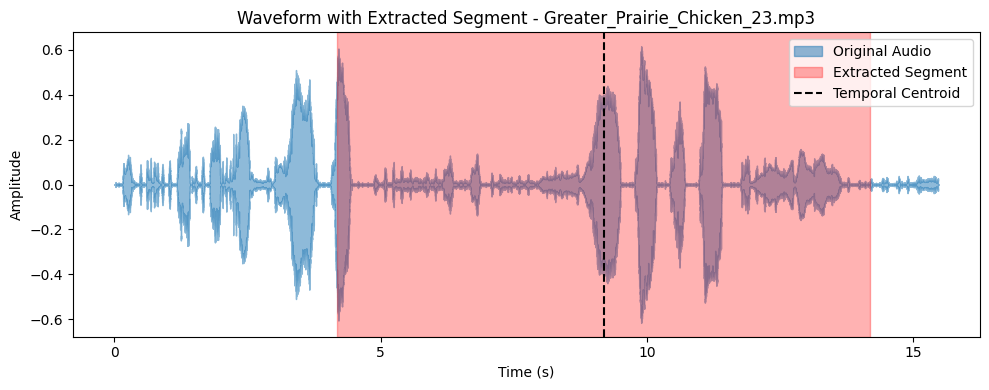

Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_21_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_20_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_9_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_30_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_24_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_18_segment.wav
Extracted segment saved to: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments/Greater_Prairie_Chicken_19_segment.wav
Extracted segment sav

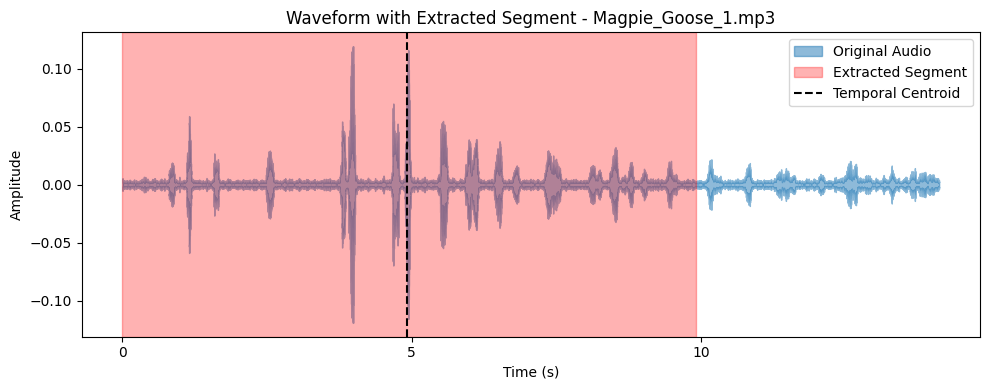

Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_5_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_4_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_6_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_7_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_9_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_8_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_10_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_11_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_so

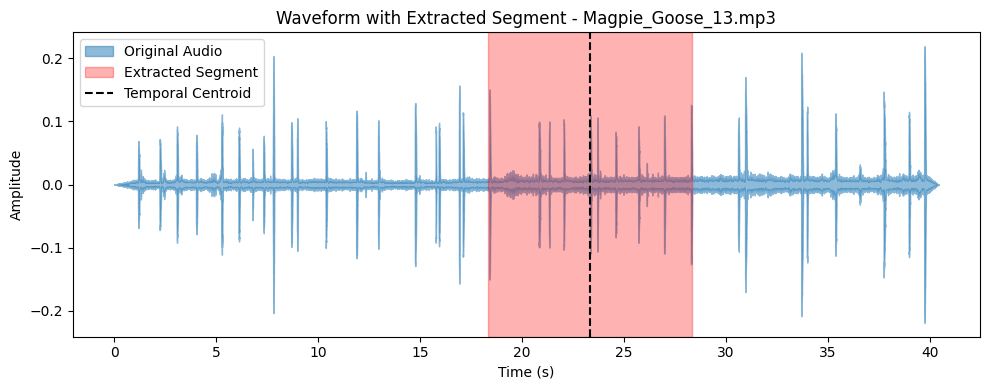

Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_12_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_16_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_17_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_15_segment.wav
Extracted segment saved to: extracted_segments/Magpie Goose_sounds_noise_reduced_segments/Magpie_Goose_14_segment.wav


In [31]:
# Function to extract segments around temporal centroids with user-specified plots
def extract_segments_around_temporal_centroid(
    input_directories, 
    output_directory, 
    segment_duration=5, 
    plot_files={}
):
    """
    Extracts segments from audio files around the temporal centroid, saves them, and plots specified files.

    Args:
    - input_directories (list): List of directories containing audio files.
    - output_directory (str): Directory to save the extracted segments.
    - segment_duration (int): Duration (in seconds) before and after the centroid to include in the segment.
    - plot_files (dict): Dictionary specifying files to plot for each species (keys are species names, values are lists of file names to plot).
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for input_dir in input_directories:
        print(f"\nProcessing directory: {input_dir}")

        # Create sub-directory for the extracted segments
        species_name = os.path.basename(input_dir)
        output_sub_dir = os.path.join(output_directory, species_name + "_segments")
        os.makedirs(output_sub_dir, exist_ok=True)

        # List all .mp3 files
        audio_files = [f for f in os.listdir(input_dir) if f.endswith(".mp3")]

        if not audio_files:
            print(f"No audio files found in {input_dir}.")
            continue

        for audio_file in audio_files:
            input_path = os.path.join(input_dir, audio_file)

            try:
                # Load the audio file
                y, sr = librosa.load(input_path, sr=None)

                # Compute energy envelope and cumulative energy (CDF of energy)
                energy_envelope = np.abs(y) ** 2
                cumulative_energy = np.cumsum(energy_envelope)
                cumulative_energy /= cumulative_energy[-1]  # Normalize to [0, 1]

                # Find the temporal centroid (cumulative energy ≈ 0.5)
                temporal_centroid_index = np.where(cumulative_energy >= 0.5)[0][0]
                temporal_centroid_time = temporal_centroid_index / sr

                # Calculate start and end times for the segment
                start_time = max(0, temporal_centroid_time - segment_duration)
                end_time = min(len(y) / sr, temporal_centroid_time + segment_duration)

                # Convert start and end times to sample indices
                start_sample = int(start_time * sr)
                end_sample = int(end_time * sr)

                # Extract the audio segment
                segment = y[start_sample:end_sample]

                # Save the extracted segment
                segment_output_path = os.path.join(output_sub_dir, f"{os.path.splitext(audio_file)[0]}_segment.wav")
                sf.write(segment_output_path, segment, sr)

                print(f"Extracted segment saved to: {segment_output_path}")

                # Plot if the file is in the user-specified list for this species
                if species_name in plot_files and audio_file in plot_files[species_name]:
                    plt.figure(figsize=(10, 4))
                    librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Original Audio")
                    plt.axvspan(start_time, end_time, color='red', alpha=0.3, label="Extracted Segment")
                    plt.axvline(temporal_centroid_time, color='black', linestyle='--', label="Temporal Centroid")
                    plt.title(f"Waveform with Extracted Segment - {audio_file}")
                    plt.xlabel("Time (s)")
                    plt.ylabel("Amplitude")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Error processing {audio_file}: {e}")

# Input directories containing noise-reduced files
noise_reduced_directories = [
    "noise_reduced_sounds/penguin_sounds_noise_reduced",
    "noise_reduced_sounds/Red-tailed Hawk_sounds_noise_reduced",
    "noise_reduced_sounds/Greater Prairie Chicken_sounds_noise_reduced",
    "noise_reduced_sounds/Magpie Goose_sounds_noise_reduced"
]

# Output directory for extracted segments
output_segments_directory = "extracted_segments"

# Specify which files to plot for each species
files_to_plot = {
    "penguin_sounds_noise_reduced": ["King_Penguin_18.mp3", "King_Penguin_23.mp3"],
    "Red-tailed Hawk_sounds_noise_reduced": ["Red-tailed_Hawk_12.mp3", "Red-tailed_Hawk_16.mp3"],
    "Greater Prairie Chicken_sounds_noise_reduced": ["Greater_Prairie_Chicken_2.mp3", "Greater_Prairie_Chicken_23.mp3"],
    "Magpie Goose_sounds_noise_reduced": ["Magpie_Goose_1.mp3", "Magpie_Goose_13.mp3"]
}

# Extract segments around the temporal centroid and plot specified files
extract_segments_around_temporal_centroid(noise_reduced_directories, output_segments_directory, plot_files=files_to_plot)



## 2.3 Bandpass Butterworth Filter

#### What is the Bandpass Butterworth Filter?
A **bandpass filter** is a signal processing technique that allows frequencies within a specific range (band) to pass through while attenuating frequencies outside that range. The **Butterworth filter** is particularly known for its smooth frequency response, which avoids abrupt changes in amplitude.

In this context, the filter is designed to:
- Allow frequencies between **500 Hz** and **8000 Hz** to pass.
- Attenuate frequencies below 500 Hz (e.g., low-frequency environmental noise) and above 8000 Hz (e.g., high-frequency interference).

#### Implementation in the Workflow
The function `butter_bandpass_filter` is used to apply the bandpass filter to audio signals. Here’s how it works:

1. **Frequency Normalization**:
   - The cutoff frequencies (`lowcut` and `highcut`) are normalized by the Nyquist frequency (half the sampling rate) to prepare them for the digital filter.
2. **Filter Design**:
   - Using the `scipy.signal.butter` function, the filter coefficients are calculated based on the desired frequency range and the filter order (e.g., 5th order).
3. **Application of the Filter**:
   - The `scipy.signal.lfilter` function applies the designed filter to the audio data, yielding the filtered signal.

#### Importance in Feature Extraction
The bandpass filter serves several crucial purposes in the preprocessing pipeline:

1. **Noise Reduction**:
   - Removes low-frequency noises (e.g., wind or vibrations) and high-frequency artifacts (e.g., electronic interference), leaving a cleaner signal.
2. **Focus on Relevant Frequencies**:
   - The selected band (500-8000 Hz) covers the typical range of bird vocalizations, ensuring that the filtered signal retains the most important features of bird calls.
3. **Improved Feature Quality**:
   - Filtering reduces the influence of irrelevant frequencies, enhancing the quality and accuracy of extracted features such as spectrograms and temporal patterns.

#### Application and Visualization
The `apply_bandpass_filter_and_plot` function applies the filter to audio segments and:
- Saves the filtered signals to an output directory for subsequent analysis.
- Optionally plots the original and filtered waveforms for selected files to visualize the effect of filtering.

This step ensures the audio signals are optimized for downstream tasks, such as clustering or classification, by focusing on the most relevant frequency components of bird calls.


Processing directory: extracted_segments/penguin_sounds_noise_reduced_segments
Filtered audio saved to: filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_23_segment.wav


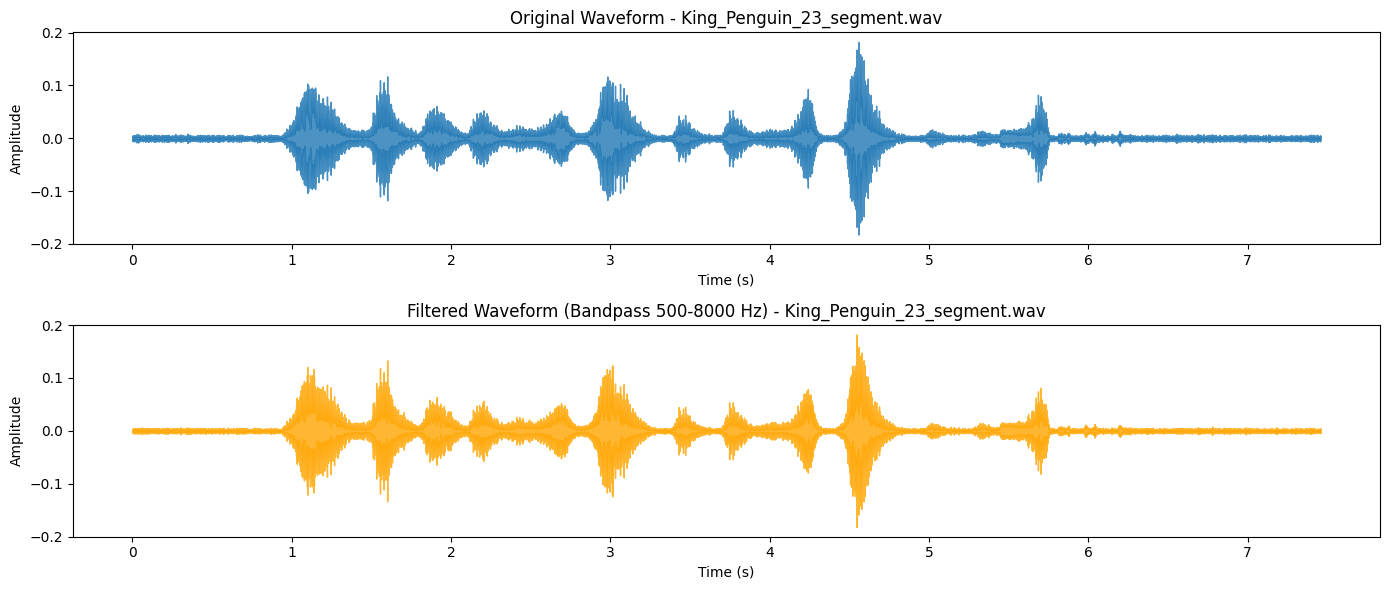

Filtered audio saved to: filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_18_segment.wav


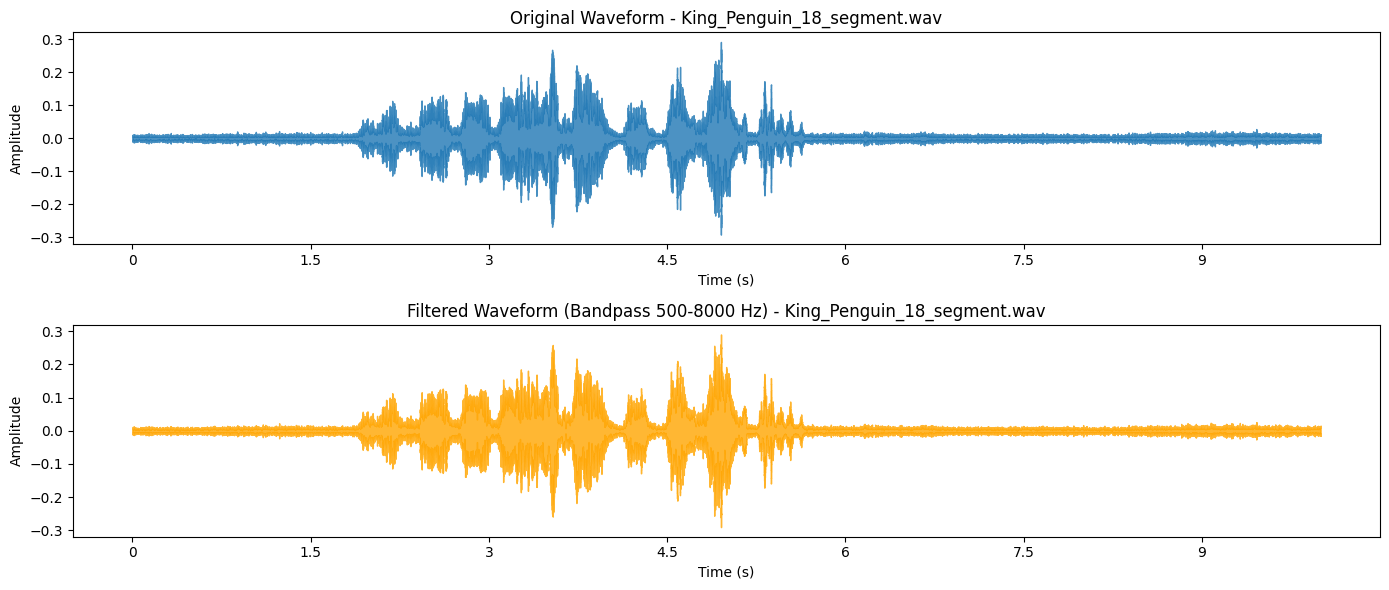


Processing directory: extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments
Filtered audio saved to: filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_12_segment.wav


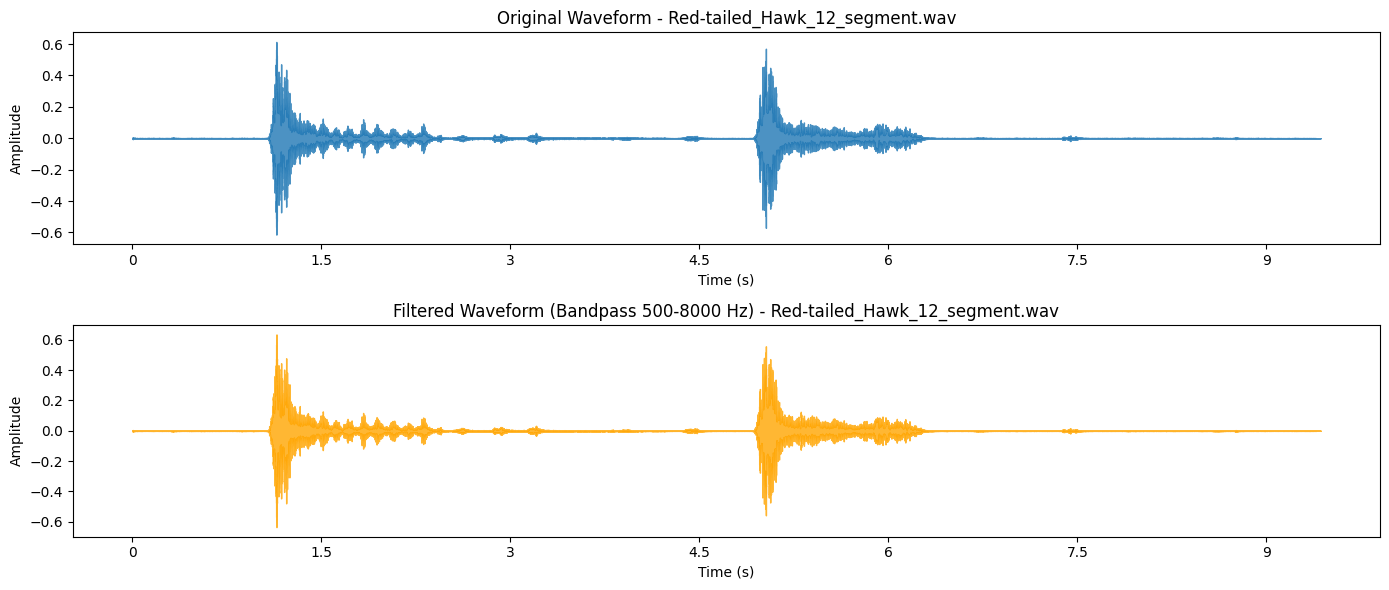

Filtered audio saved to: filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_16_segment.wav


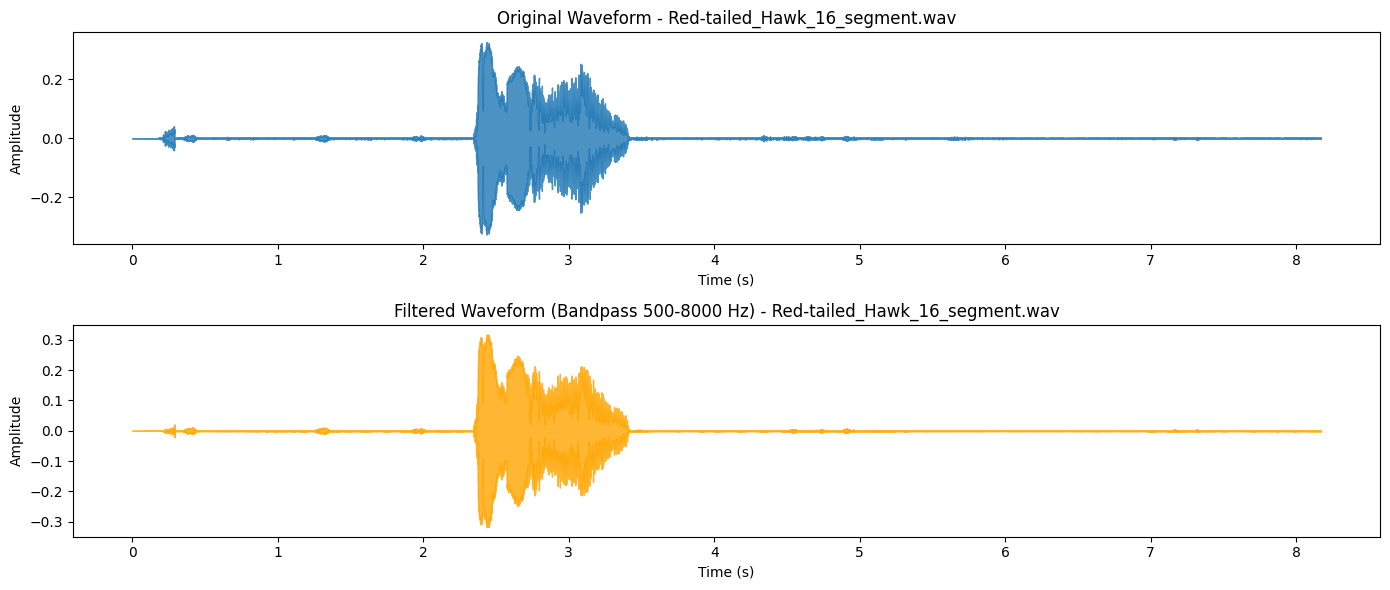


Processing directory: extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments
Filtered audio saved to: filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_23_segment.wav


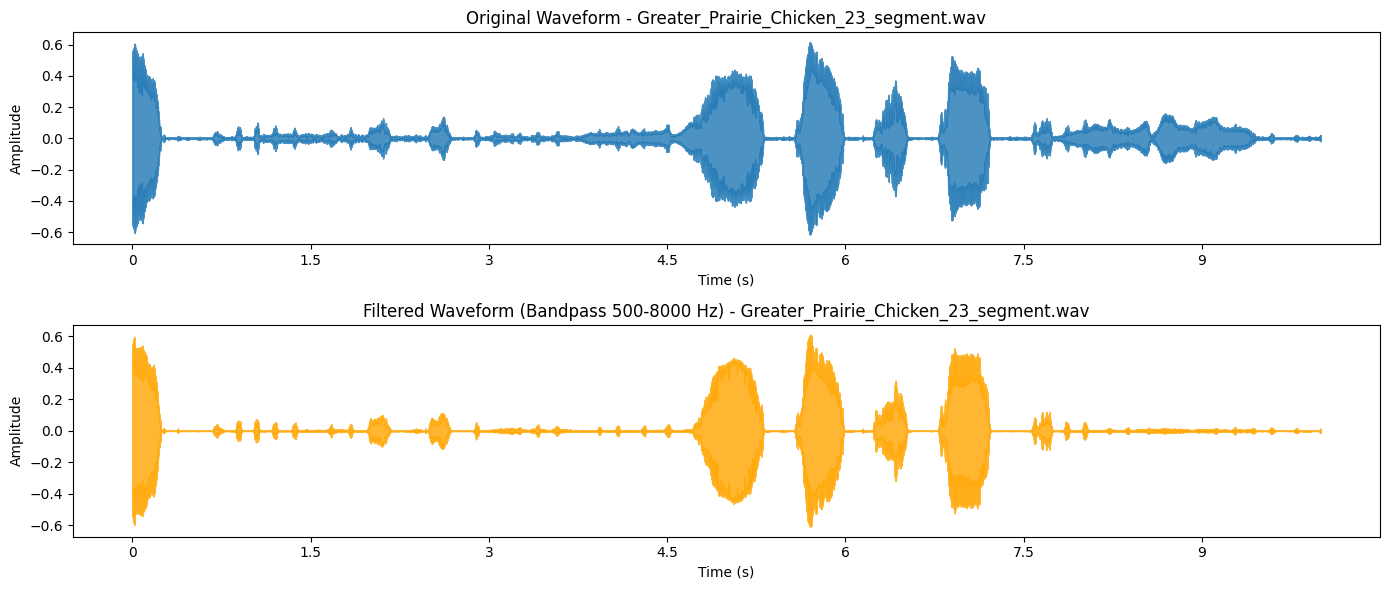

Filtered audio saved to: filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_2_segment.wav


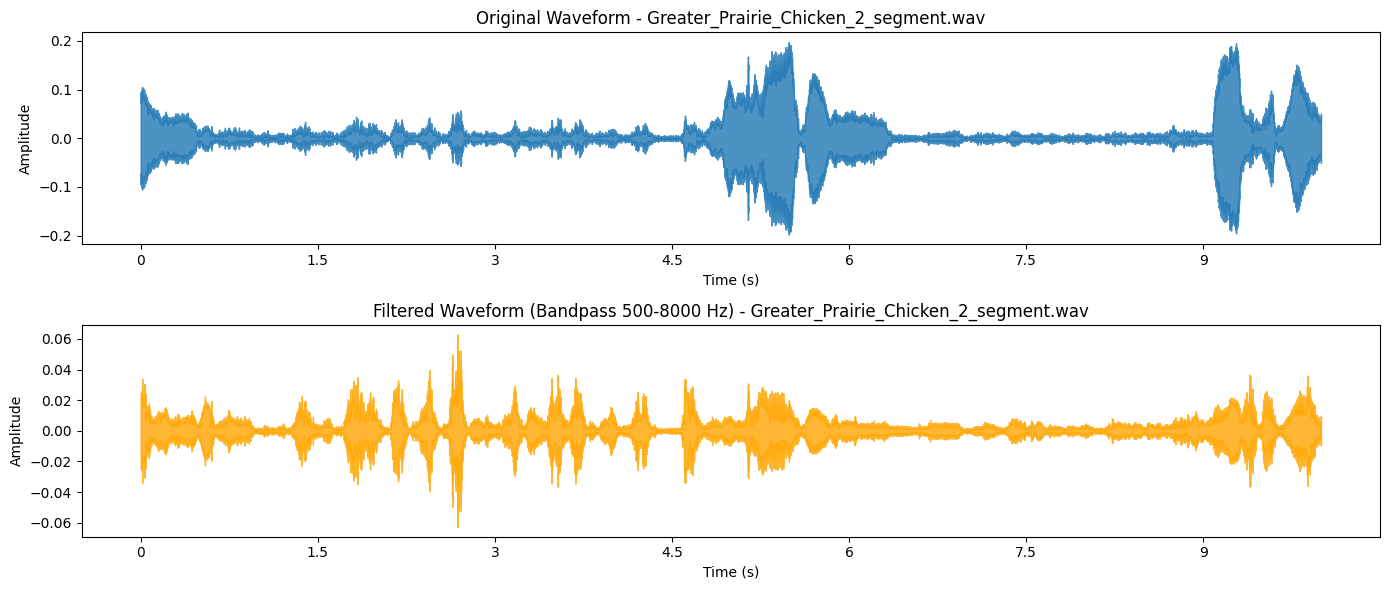


Processing directory: extracted_segments/Magpie Goose_sounds_noise_reduced_segments
Filtered audio saved to: filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_13_segment.wav


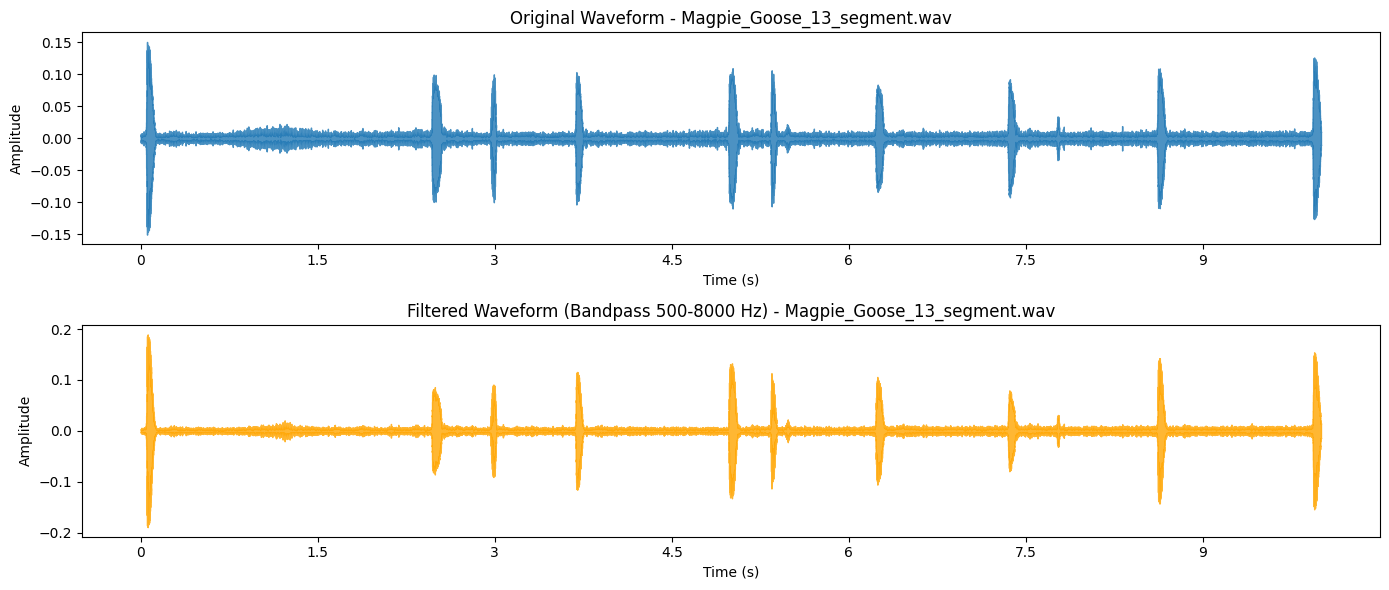

Filtered audio saved to: filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_1_segment.wav


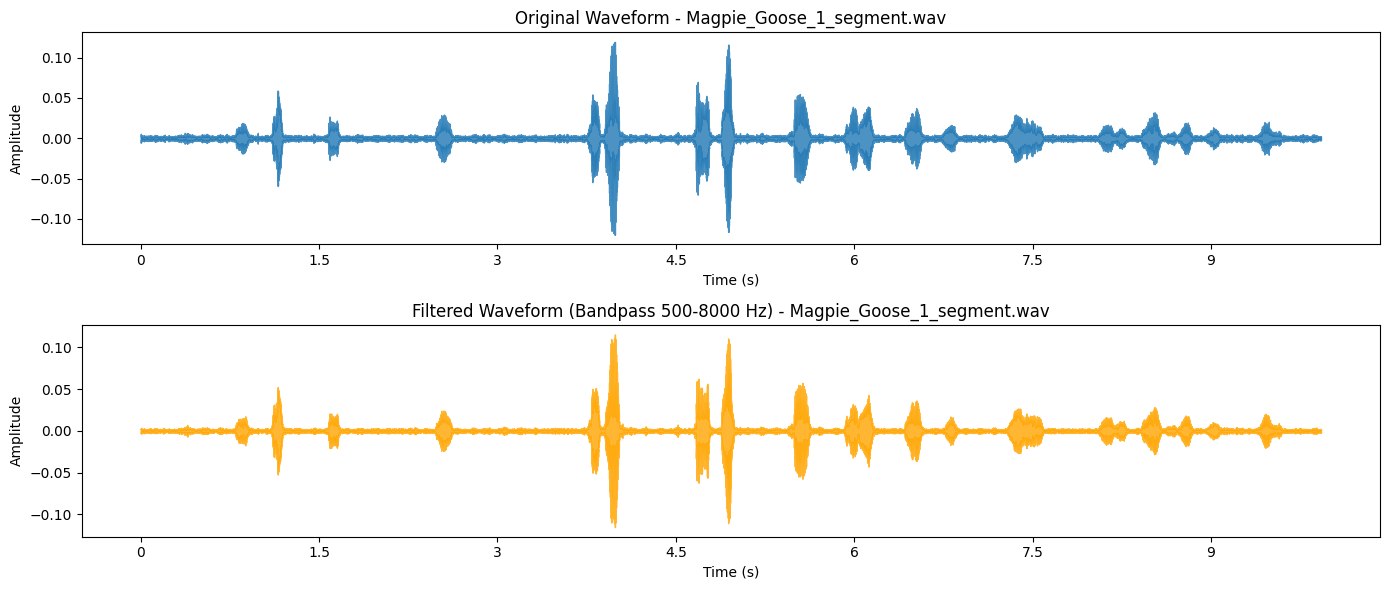

In [32]:

# Function to create a bandpass Butterworth filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a bandpass Butterworth filter.

    Args:
    - data (ndarray): Audio data to filter.
    - lowcut (float): Lower cutoff frequency in Hz.
    - highcut (float): Upper cutoff frequency in Hz.
    - fs (int): Sampling rate in Hz.
    - order (int): Order of the filter.

    Returns:
    - ndarray: Filtered audio data.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist  # Normalize lower cutoff frequency
    high = highcut / nyquist  # Normalize upper cutoff frequency
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Apply bandpass filter to specified segments and save them, while plotting only selected files
def apply_bandpass_filter_and_plot(input_directories, output_directory, lowcut=500, highcut=8000, files_to_process={}):
    """
    Apply a bandpass filter to specified audio segments, save all filtered files,
    and plot the original and filtered waveforms for specified files.

    Args:
    - input_directories (list): List of directories with audio segments.
    - output_directory (str): Directory to save the filtered audio segments.
    - lowcut (float): Lower cutoff frequency in Hz.
    - highcut (float): Upper cutoff frequency in Hz.
    - files_to_process (dict): Dictionary specifying files to plot (keys are species, values are lists of file names).
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for input_dir in input_directories:
        print(f"\nProcessing directory: {input_dir}")

        species_name = os.path.basename(input_dir)
        output_sub_dir = os.path.join(output_directory, species_name + "_filtered")
        os.makedirs(output_sub_dir, exist_ok=True)

        audio_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]

        if not audio_files:
            print(f"No audio files found in {input_dir}.")
            continue

        # Filter files based on user selection
        if species_name in files_to_process:
            audio_files = [f for f in audio_files if f in files_to_process[species_name]]

        for audio_file in audio_files:
            input_path = os.path.join(input_dir, audio_file)

            try:
                # Load the audio file
                y, sr = librosa.load(input_path, sr=None)

                # Apply the bandpass filter
                filtered_audio = butter_bandpass_filter(y, lowcut=lowcut, highcut=highcut, fs=sr)

                # Save the filtered segment
                output_path = os.path.join(output_sub_dir, audio_file)
                sf.write(output_path, filtered_audio, sr)
                print(f"Filtered audio saved to: {output_path}")

                # Plot only if the file is in files_to_process for the species
                if species_name in files_to_process and audio_file in files_to_process[species_name]:
                    # Plot original and filtered waveforms
                    plt.figure(figsize=(14, 6))
                    plt.subplot(2, 1, 1)
                    librosa.display.waveshow(y, sr=sr, alpha=0.8)
                    plt.title(f"Original Waveform - {audio_file}", fontsize=12)
                    plt.xlabel("Time (s)", fontsize=10)
                    plt.ylabel("Amplitude", fontsize=10)

                    plt.subplot(2, 1, 2)
                    librosa.display.waveshow(filtered_audio, sr=sr, alpha=0.8, color='orange')
                    plt.title(f"Filtered Waveform (Bandpass {lowcut}-{highcut} Hz) - {audio_file}", fontsize=12)
                    plt.xlabel("Time (s)", fontsize=10)
                    plt.ylabel("Amplitude", fontsize=10)

                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Error processing {audio_file}: {e}")

# Directories of extracted segments
extracted_segments_directories = [
    "extracted_segments/penguin_sounds_noise_reduced_segments",
    "extracted_segments/Red-tailed Hawk_sounds_noise_reduced_segments",
    "extracted_segments/Greater Prairie Chicken_sounds_noise_reduced_segments",
    "extracted_segments/Magpie Goose_sounds_noise_reduced_segments"
]

# Output directory for filtered segments
filtered_segments_directory = "filtered_segments"

# Specify files to process for each species (for plotting)
files_to_process = {
    "penguin_sounds_noise_reduced_segments": ["King_Penguin_18_segment.wav", "King_Penguin_23_segment.wav"],
    "Red-tailed Hawk_sounds_noise_reduced_segments": ["Red-tailed_Hawk_12_segment.wav", "Red-tailed_Hawk_16_segment.wav"],
    "Greater Prairie Chicken_sounds_noise_reduced_segments": ["Greater_Prairie_Chicken_2_segment.wav", "Greater_Prairie_Chicken_23_segment.wav"],
    "Magpie Goose_sounds_noise_reduced_segments": ["Magpie_Goose_1_segment.wav", "Magpie_Goose_13_segment.wav"]
}

# Apply bandpass filter and save all filtered files while plotting only selected files
apply_bandpass_filter_and_plot(
    extracted_segments_directories, 
    filtered_segments_directory, 
    lowcut=500, 
    highcut=8000, 
    files_to_process=files_to_process
)


# 3. Feature Extraction
## 3.1 Fourier Transform
### What is the Fourier Transform?
The **Fourier Transform (FT)** is a mathematical technique used to transform a signal from its time domain representation to its frequency domain representation. It decomposes a complex signal into its constituent sinusoidal components, allowing the analysis of the amplitude and phase of each frequency present in the signal.

#### Why Use Fourier Transform in Bird Call Analysis?
1. **Frequency Domain Features**:
   - Many bird calls are characterized by distinct frequency patterns. The FT helps identify these patterns by showing which frequencies are dominant.
2. **Noise Identification**:
   - It highlights noise components (e.g., low-frequency hums or high-frequency interference), aiding in signal preprocessing.
3. **Data Reduction**:
   - Extracting features in the frequency domain often simplifies data and highlights essential components.

#### Implementation Steps
1. **Compute the FFT**:
   - The **Fast Fourier Transform (FFT)**, an efficient algorithm for computing the FT, is used to convert a segment of the bird call signal into its frequency components.
2. **Amplitude Spectrum**:
   - The result of the FFT is a complex number for each frequency, and the amplitude spectrum is obtained by calculating the magnitude of these complex numbers.
3. **Visualization**:
   - The spectrum is plotted to visualize the distribution of energy across frequencies.

#### Importance of the Fourier Transform
- **Understanding Bird Calls**:
   - Many bird species have unique frequency signatures in their calls. The FT helps in isolating these signatures for classification or clustering.
- **Preprocessing Validation**:
   - After filtering or other preprocessing steps, the FT can verify that noise has been removed, and the relevant frequency band has been retained.

By incorporating Fourier analysis, this project ensures a comprehensive approach to signal analysis, leveraging both time and frequency domain insights to enhance feature extraction and classification.


Processing file: filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_10_segment.wav
Visualizing segment for: King_Penguin_10_segment.wav


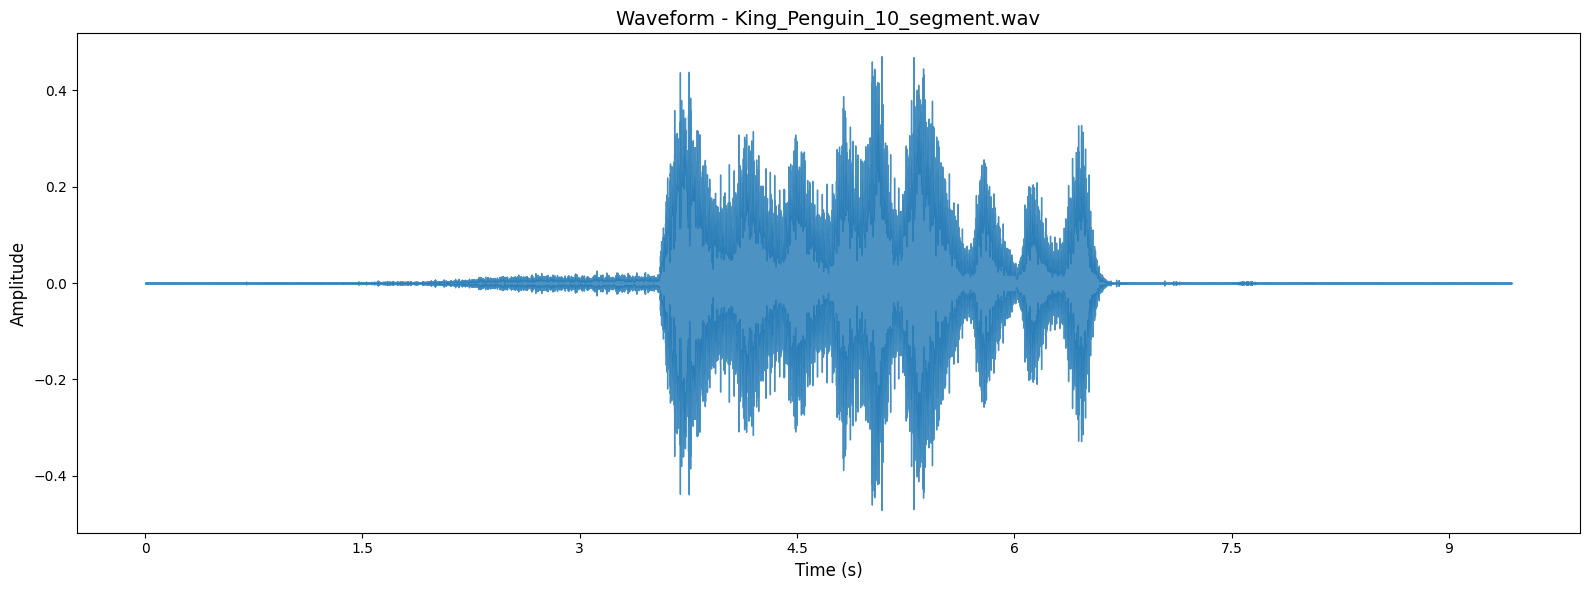

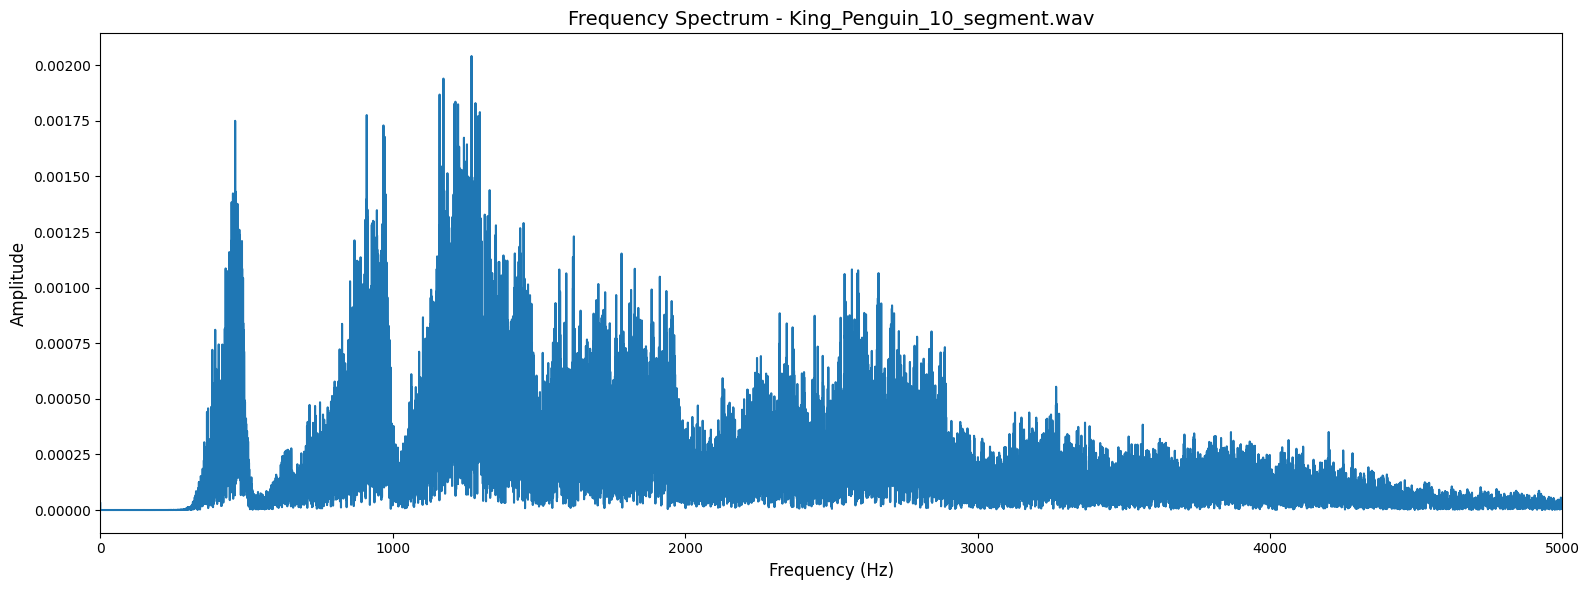


Processing file: filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_11_segment.wav
Visualizing segment for: King_Penguin_11_segment.wav


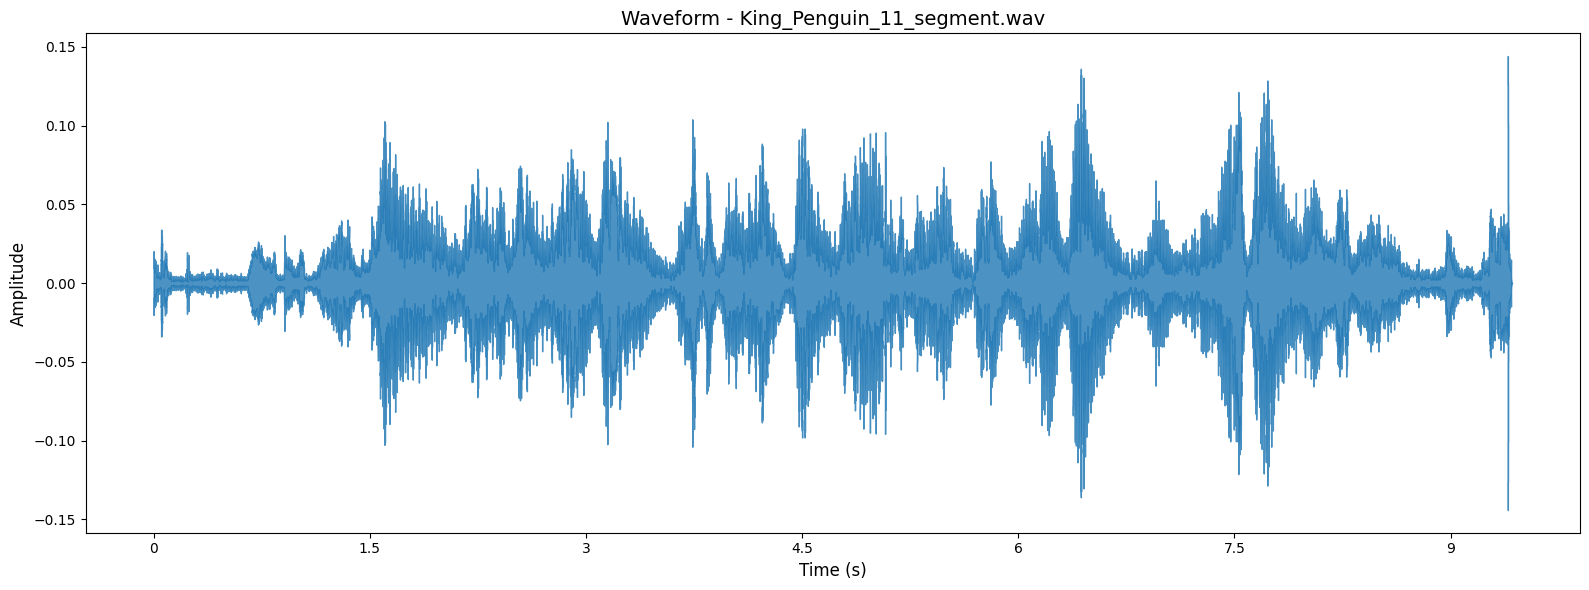

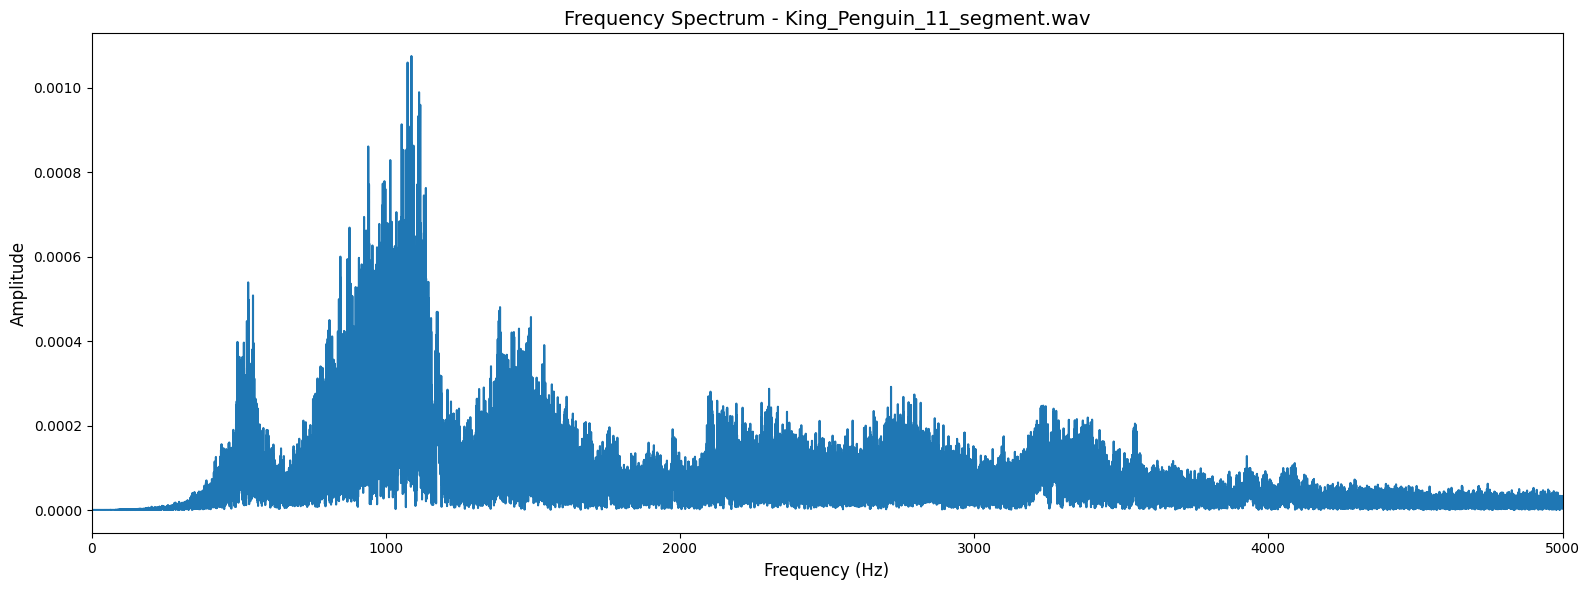


Processing file: filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_1_segment.wav
Visualizing segment for: Magpie_Goose_1_segment.wav


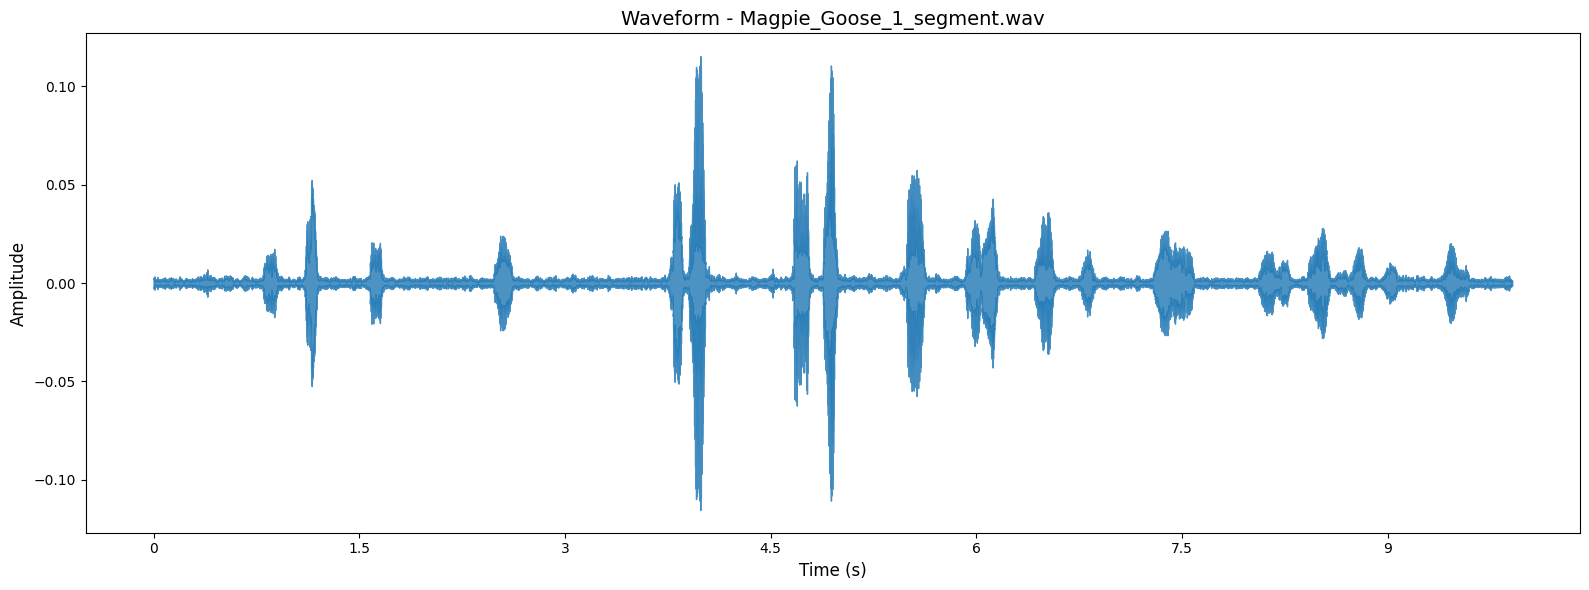

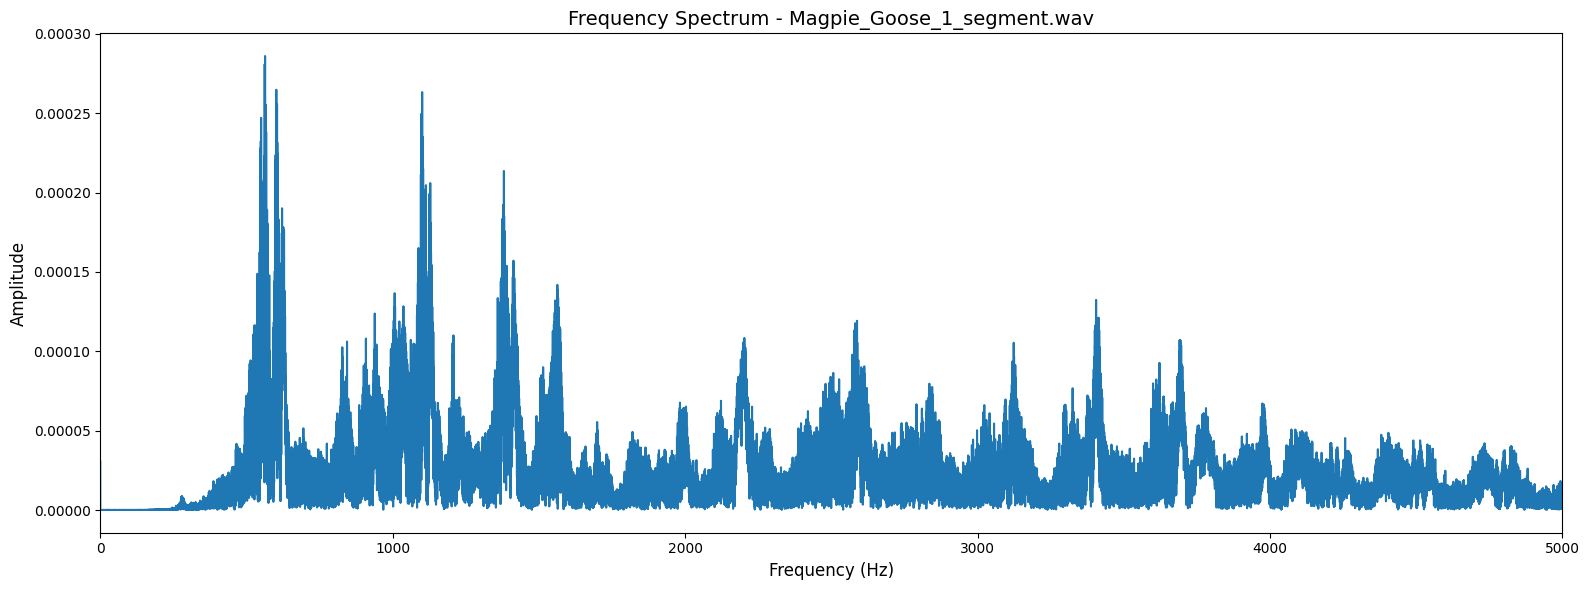


Processing file: filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_20_segment.wav
Visualizing segment for: Magpie_Goose_20_segment.wav


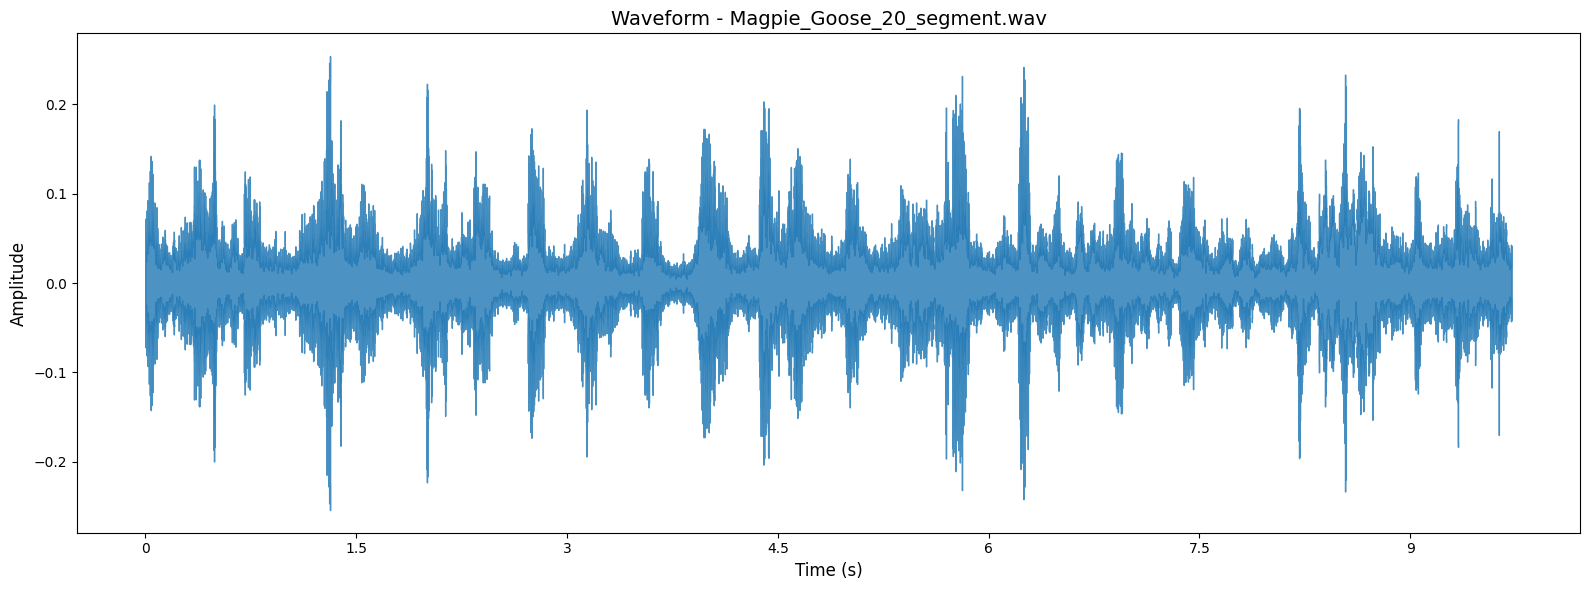

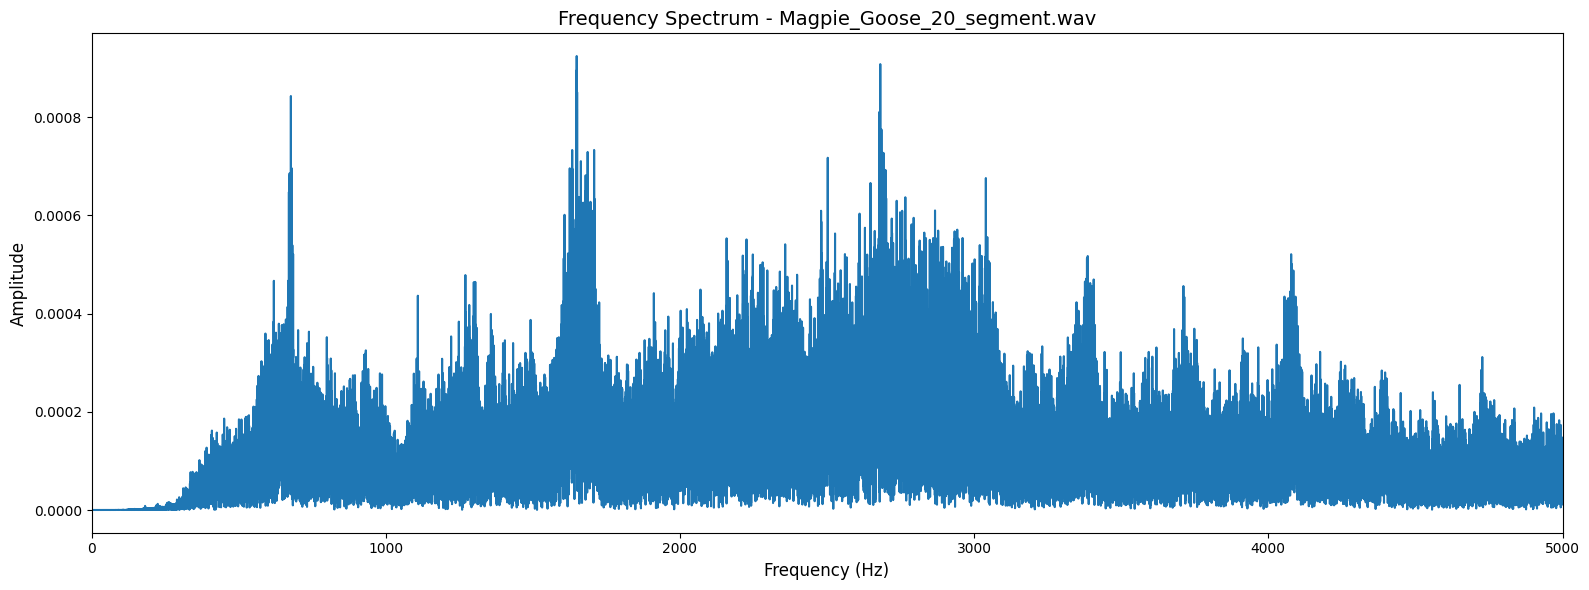


Processing file: filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_2_segment.wav
Visualizing segment for: Red-tailed_Hawk_2_segment.wav


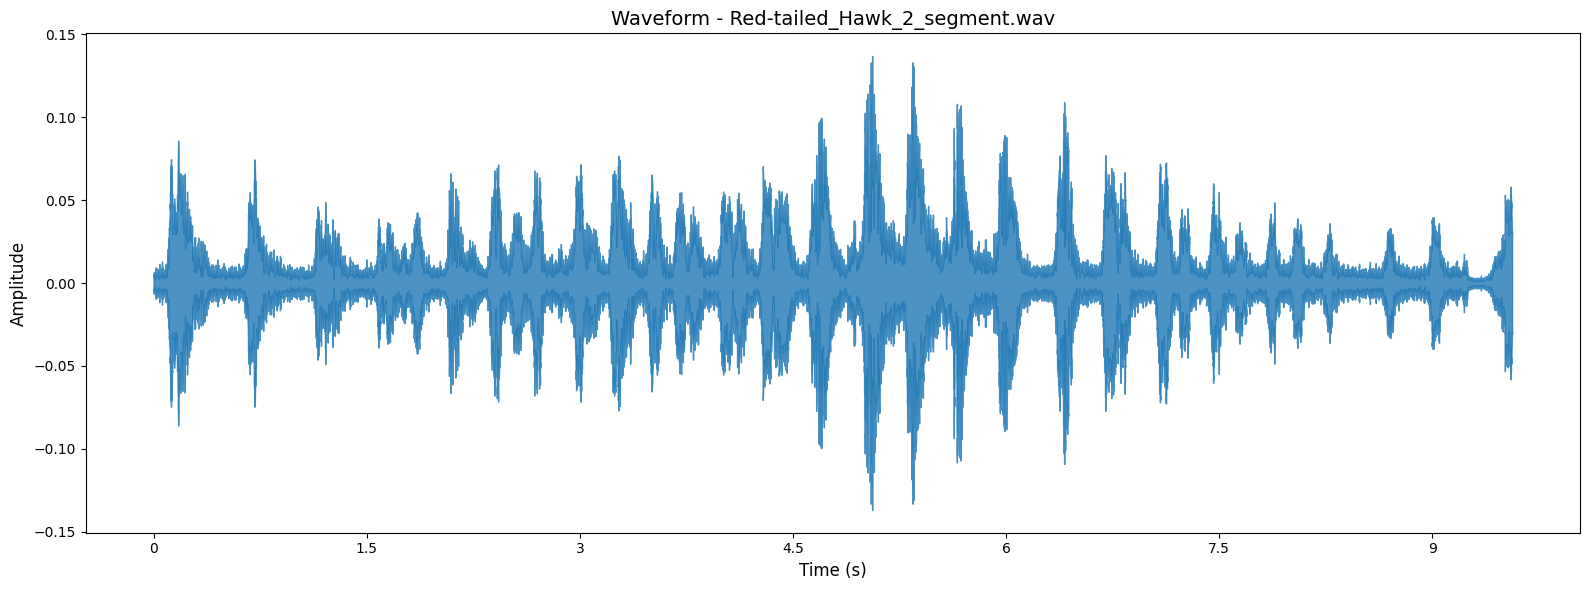

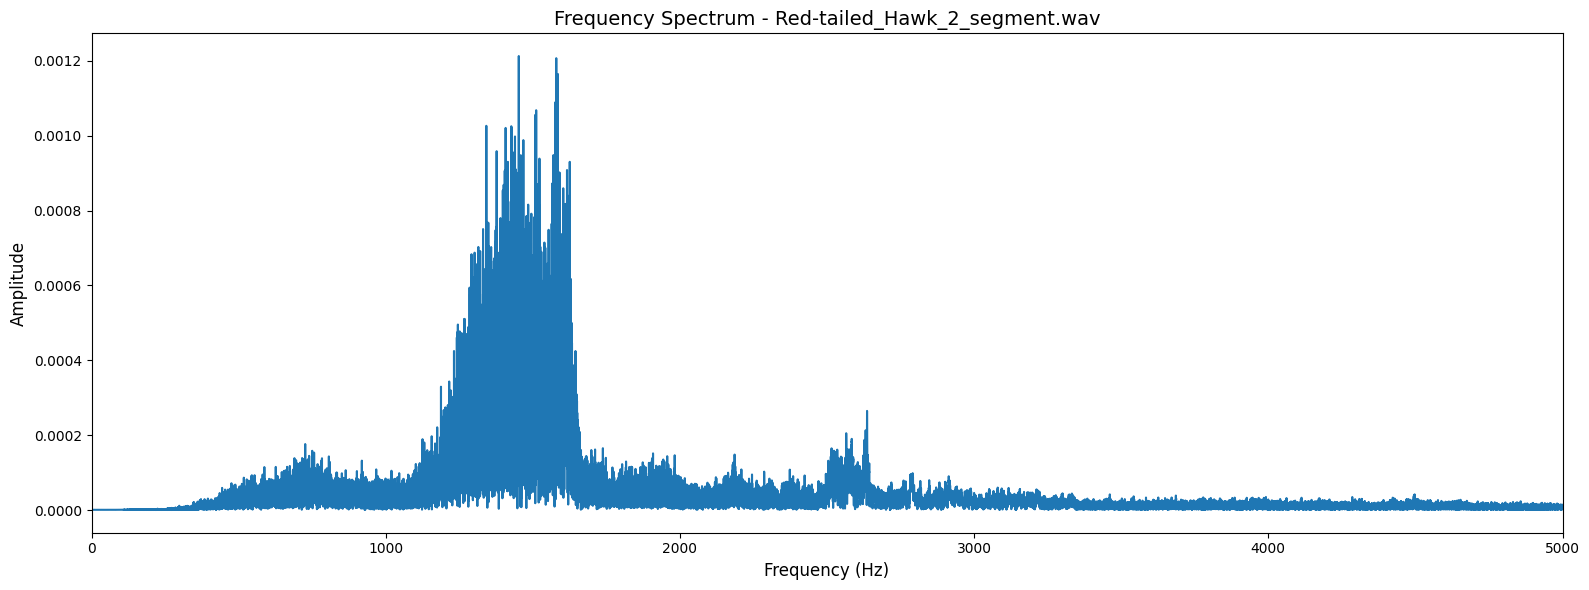


Processing file: filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_3_segment.wav
Visualizing segment for: Red-tailed_Hawk_3_segment.wav


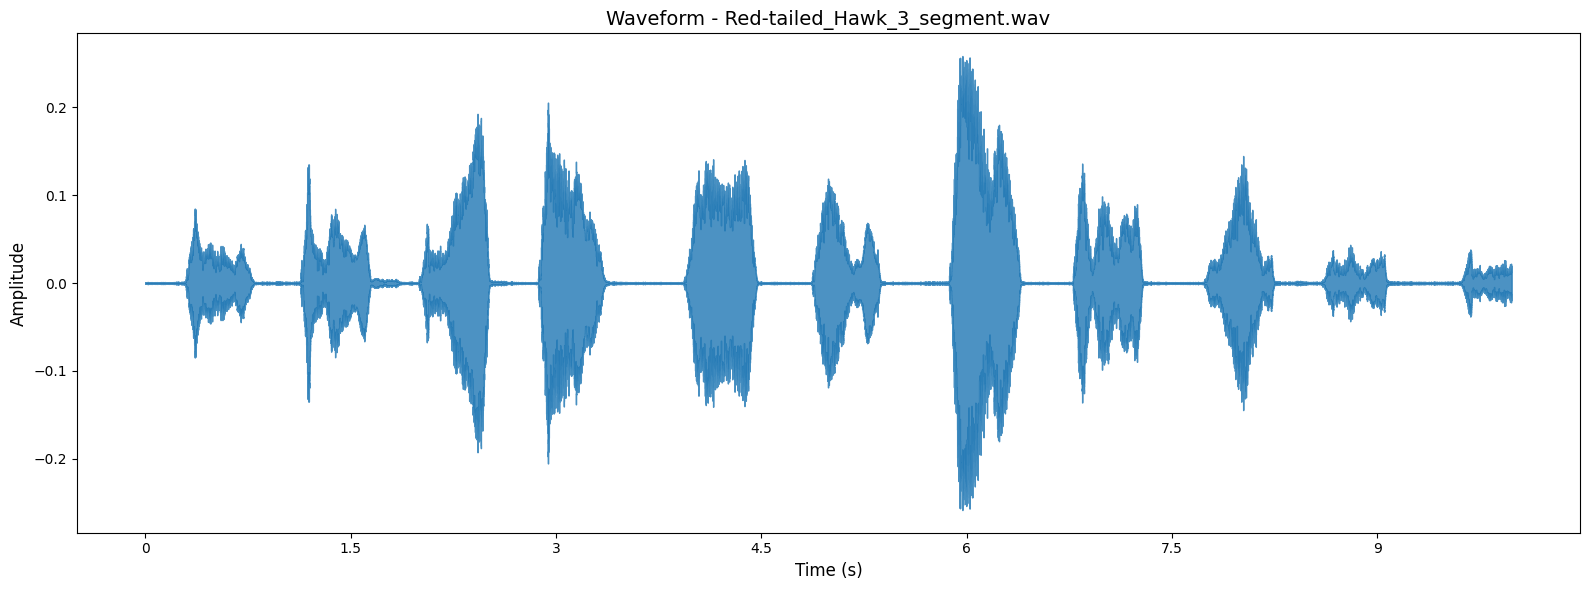

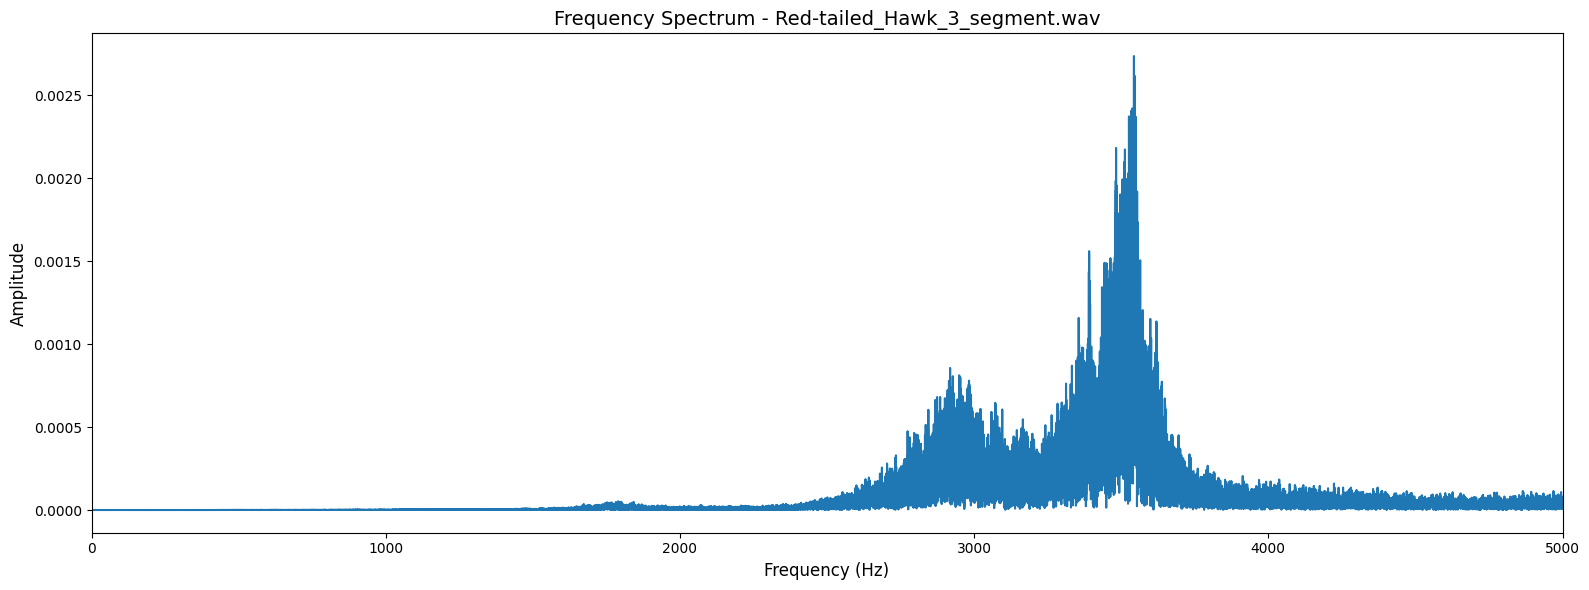


Processing file: filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_1_segment.wav
Visualizing segment for: Greater_Prairie_Chicken_1_segment.wav


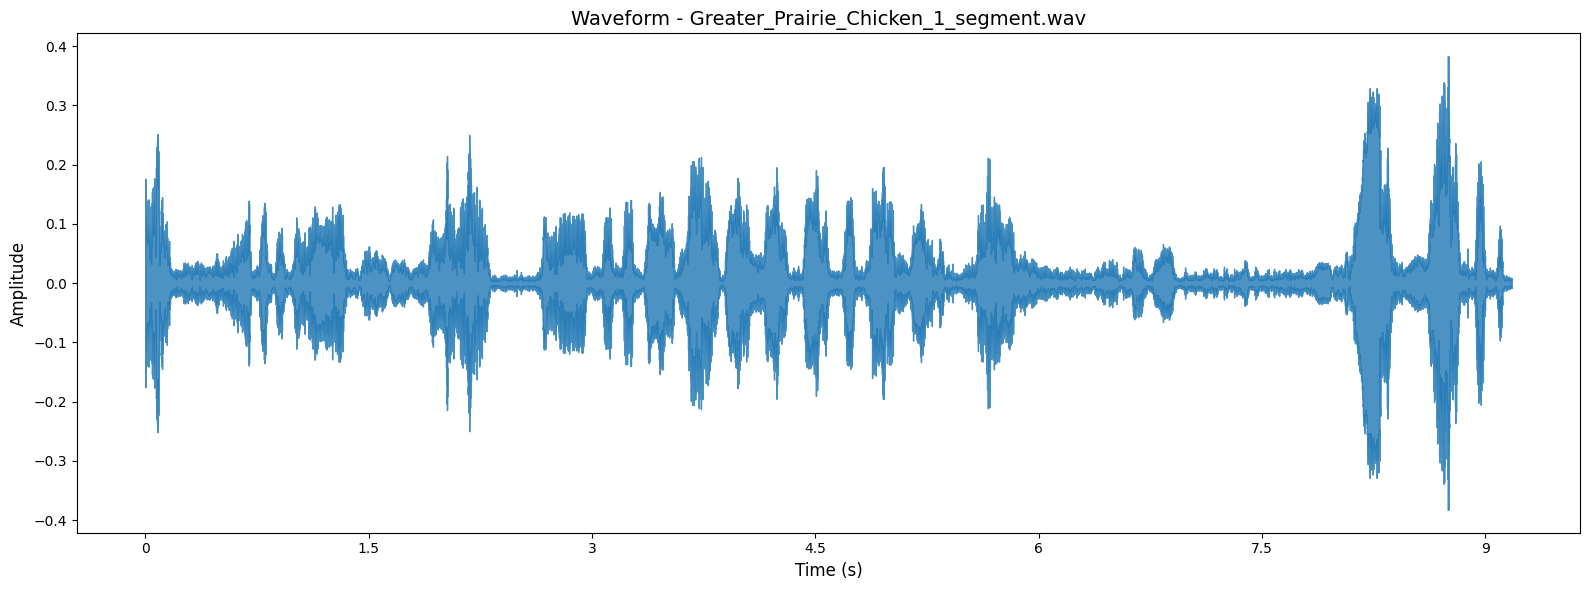

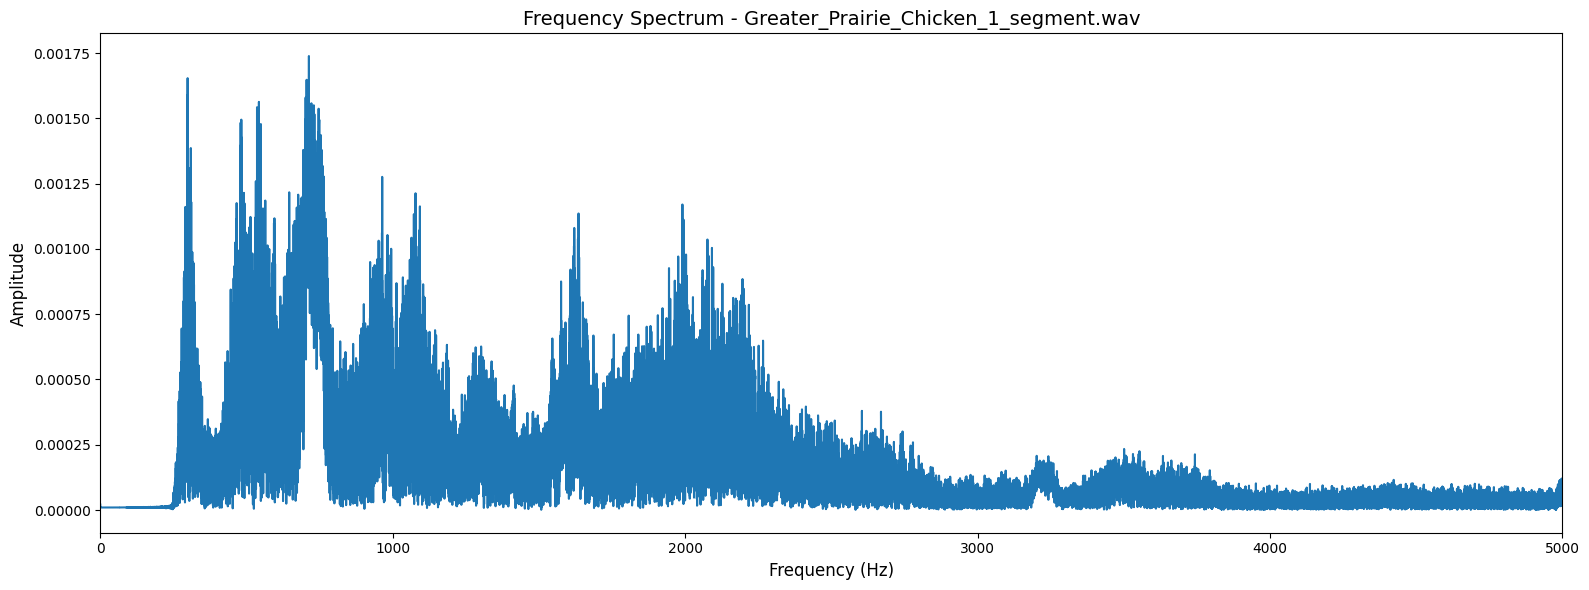


Processing file: filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_2_segment.wav
Visualizing segment for: Greater_Prairie_Chicken_2_segment.wav


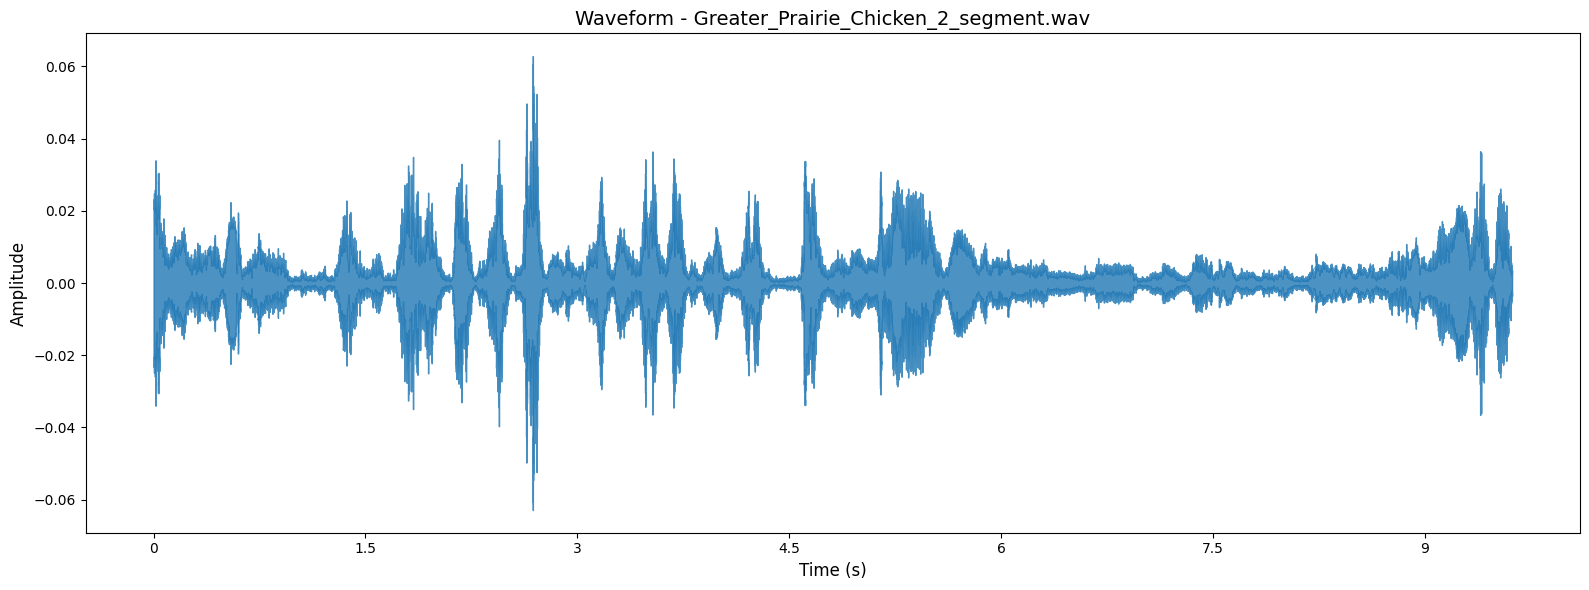

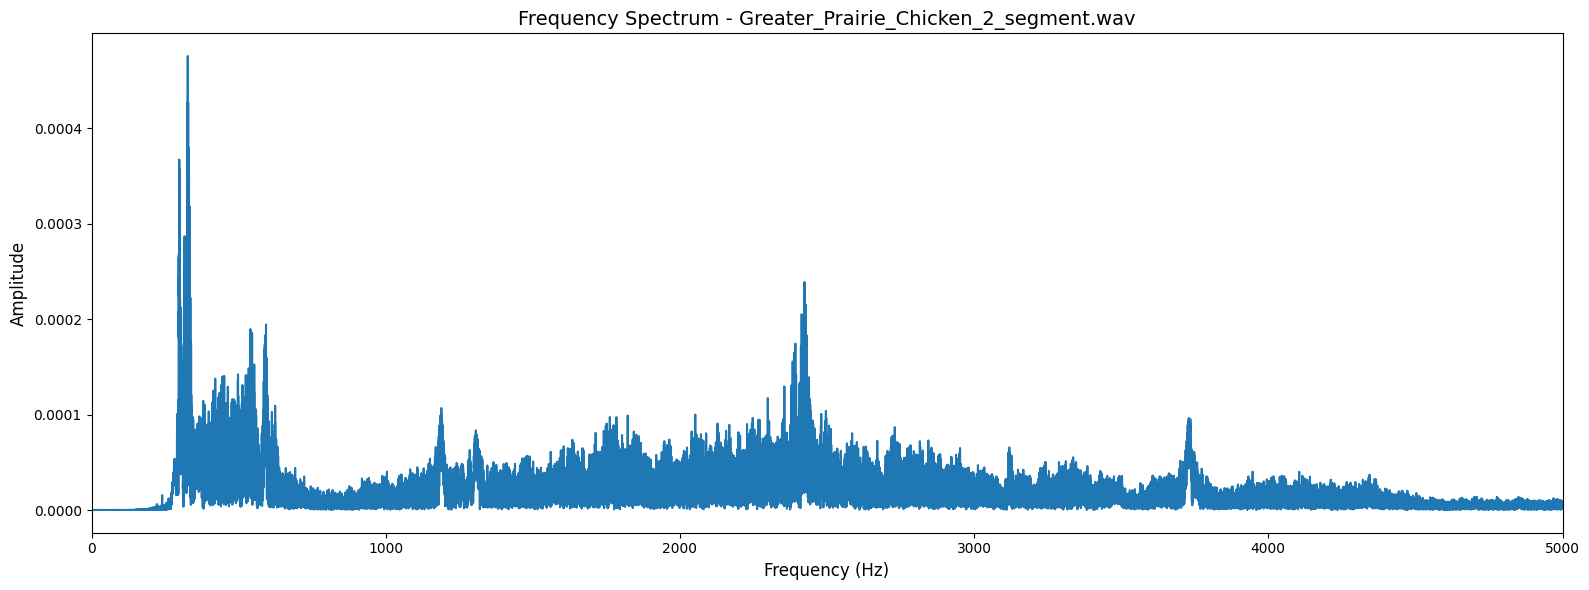

In [33]:

def visualize_segments(input_path, segment_duration=5):
    print(f"\nProcessing file: {input_path}")

    if not os.path.isfile(input_path):
        print(f"File does not exist: {input_path}")
        return

    try:
        y, sr = librosa.load(input_path, sr=None)

        energy_envelope = np.abs(y) ** 2
        cumulative_energy = np.cumsum(energy_envelope)
        cumulative_energy /= cumulative_energy[-1]

        temporal_centroid_index = np.where(cumulative_energy >= 0.5)[0][0]
        temporal_centroid_time = temporal_centroid_index / sr

        start_time = max(0, temporal_centroid_time - segment_duration)
        end_time = min(len(y) / sr, temporal_centroid_time + segment_duration)

        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        segment = y[start_sample:end_sample]

        print(f"Visualizing segment for: {os.path.basename(input_path)}")

        # Plot waveform (Amplitude x Time)
        plt.figure(figsize=(16, 6))
        librosa.display.waveshow(segment, sr=sr, alpha=0.8)
        plt.title(f"Waveform - {os.path.basename(input_path)}", fontsize=14)
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Apply Fourier Transform and plot (Frequency x Amplitude)
        N = len(segment)
        T = 1.0 / sr
        yf = fft(segment)
        xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
        
        plt.figure(figsize=(16, 6))
        plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
        plt.xlim(0, 5000)  # Limit frequency range to 5000 Hz for better readability
        plt.title(f"Frequency Spectrum - {os.path.basename(input_path)}", fontsize=14)
        plt.xlabel("Frequency (Hz)", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {input_path}: {e}")


visualize_segments("filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_10_segment.wav")
visualize_segments("filtered_segments/penguin_sounds_noise_reduced_segments_filtered/King_Penguin_11_segment.wav")

visualize_segments("filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_1_segment.wav")
visualize_segments("filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_20_segment.wav")

visualize_segments("filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_2_segment.wav")
visualize_segments("filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered/Red-tailed_Hawk_3_segment.wav")

visualize_segments("filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_1_segment.wav")
visualize_segments("filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered/Greater_Prairie_Chicken_2_segment.wav")


### 3D Visualization of Audio Segments: Time (x-axis), Frequency (y-axis), and Amplitude (z-axis) showcasing waveform (black) and FFT (red). 


Processing file: filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_20_segment.wav


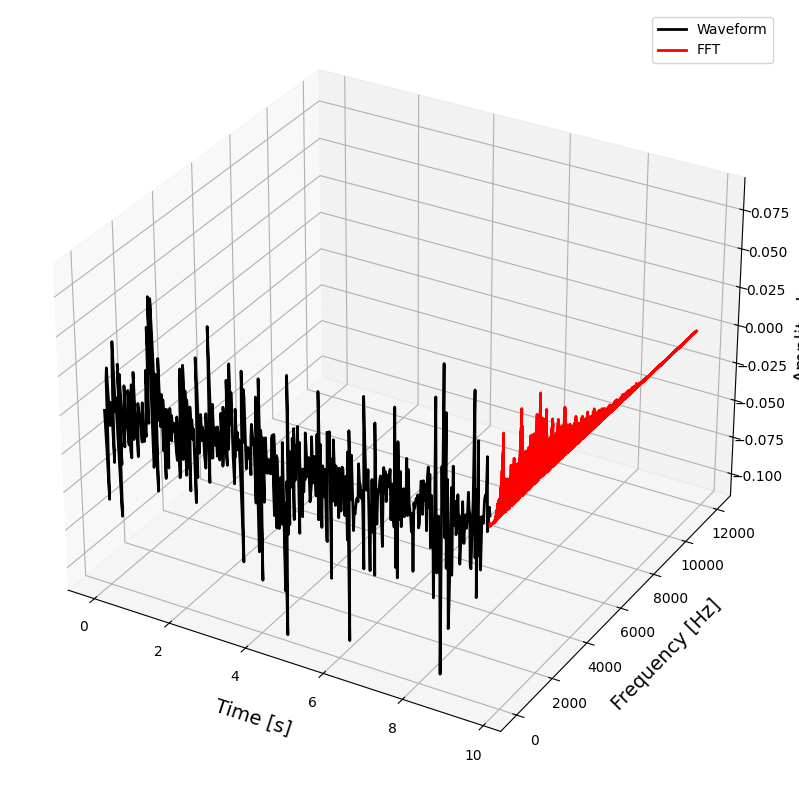

In [34]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from mpl_toolkits.mplot3d import Axes3D

def get_fft_values(signal, T, N, f_s):
    yf = fft(signal)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    return xf, 2.0 / N * np.abs(yf[:N // 2])

def visualize_segments_3d(input_path, segment_duration=5):
    print(f"\nProcessing file: {input_path}")

    if not os.path.isfile(input_path):
        print(f"File does not exist: {input_path}")
        return

    try:
        y, sr = librosa.load(input_path, sr=None)

        energy_envelope = np.abs(y) ** 2
        cumulative_energy = np.cumsum(energy_envelope)
        cumulative_energy /= cumulative_energy[-1]

        temporal_centroid_index = np.where(cumulative_energy >= 0.5)[0][0]
        temporal_centroid_time = temporal_centroid_index / sr

        start_time = max(0, temporal_centroid_time - segment_duration)
        end_time = min(len(y) / sr, temporal_centroid_time + segment_duration)

        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        segment = y[start_sample:end_sample]

        T = 1.0 / sr  # Sampling interval
        N = len(segment)
        f_s = sr  # Sampling frequency

        # FFT values
        f_values, fft_values = get_fft_values(segment, T, N, f_s)
        times = np.linspace(start_time, end_time, len(segment))

        # Reduce data points to avoid memory issues
        downsample_factor = max(1, len(segment) // 500)  # Reduce to ~500 points max
        segment = segment[::downsample_factor]
        times = times[::downsample_factor]
        fft_values = fft_values[:len(f_values) // 2]  # Take half for positive frequencies
        f_values = f_values[:len(f_values) // 2]

        # 3D Plot setup
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel("\nTime [s]", fontsize=14)
        ax.set_ylabel("\nFrequency [Hz]", fontsize=14)
        ax.set_zlabel("\nAmplitude", fontsize=14)

        # Plot waveform as black line
        ax.plot(times, [0] * len(times), segment, linewidth=2, color='black', label="Waveform")

        # Highlight FFT as red overlay
        fft_x = [times[-1]] * len(f_values)
        fft_y = f_values
        fft_z = fft_values * 60
        ax.plot(fft_x, fft_y, fft_z, linewidth=2, color='red', label="FFT")

        plt.tight_layout()
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error processing {input_path}: {e}")

# Replace with the path to the file you want to process
visualize_segments_3d("filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_20_segment.wav")



## Log-Mel Spectrogram

A **Log-Mel Spectrogram** is a time-frequency representation of audio, optimized to mimic human hearing. It combines the **Mel Scale**, which reflects human auditory perception, with a logarithmic scale for intensity.


### Why Use It?

- **Human-Like Perception**: Highlights frequencies we’re more sensitive to.
- **Machine Learning Features**: Common input for speech recognition, music analysis, and sound classification.
- **Visualization**: Intuitively displays frequency content over time.


### Applications

- **Speech Recognition**  
- **Music Genre/Emotion Analysis**  
- **Environmental Sound Classification**  

A Log-Mel Spectrogram is essential for audio analysis and machine learning tasks.

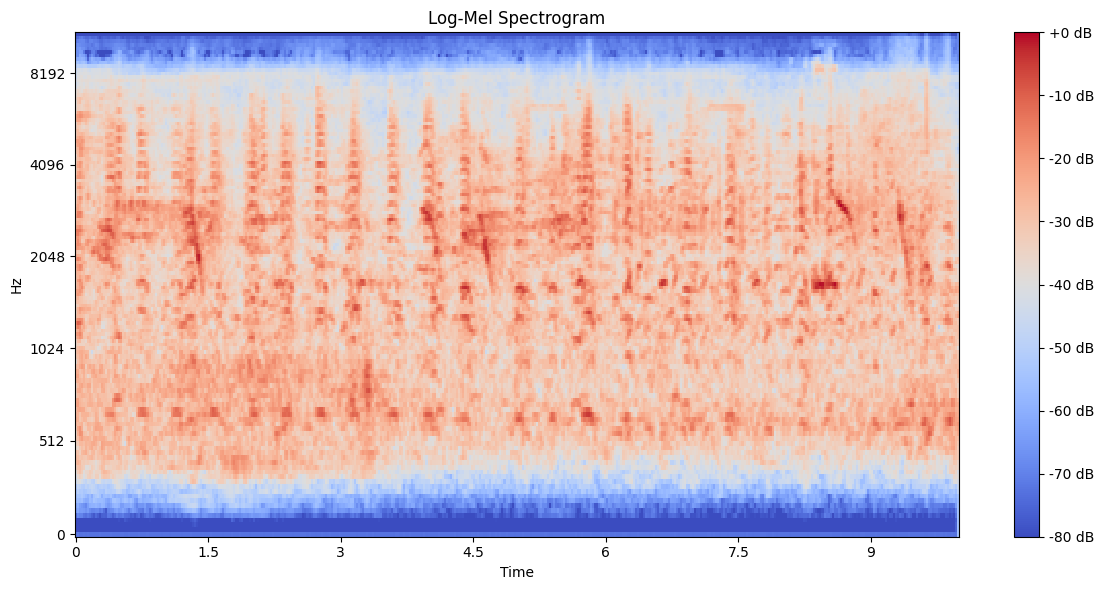

In [35]:
def plot_logmel_spectrogram(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    """
    Gera e plota o Log-Mel Spectrogram de um arquivo de áudio.

    Args:
        file_path (str): Caminho para o arquivo de áudio.
        sr (int): Taxa de amostragem padrão (default: 22050 Hz).
        n_fft (int): Tamanho da FFT (default: 2048).
        hop_length (int): Número de amostras entre frames (default: 512).
        n_mels (int): Número de bandas Mel (default: 128).

    Returns:
        None
    """
    # Carregar o áudio
    y, sr = librosa.load(file_path, sr=sr)
    
    # Remover silêncios
    y, _ = librosa.effects.trim(y)
    
    # Calcular o espectrograma de Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Converter para escala logarítmica
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Plotar o Log-Mel Spectrogram
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()

# Exemplo de uso
plot_logmel_spectrogram("filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered/Magpie_Goose_20_segment.wav")

## Feature Extraction
**Feature extraction is a critical step in audio signal analysis, particularly when studying complex sounds like bird calls. By extracting meaningful features, we can quantitatively represent the audio data, enabling better classification, recognition, and analysis. Each feature provides unique insights into different aspects of the sound, such as pitch, energy, or spectral characteristics, which are essential for understanding and distinguishing various audio patterns. Below is an overview of key features commonly used in audio analysis and their relevance to the study of bird calls.**
### Extracted Features and Their Relevance

#### 1. Zero Crossing Rate (ZCR)
- **What is it?** Measures how often the signal crosses the zero amplitude axis.
- **Relevance**: Useful for identifying noisy or percussive sounds. Bird calls with sharp changes may show higher ZCR.


#### 2. RMS Energy (Root Mean Square)
- **What is it?** The average energy of the audio signal.
- **Relevance**: Differentiates between soft and loud calls. Low RMS suggests quiet or distant calls.


#### 3. Spectral Centroid
- **What is it?** The center of mass of the spectrum.
- **Relevance**: High centroids indicate brighter or higher-pitched calls.


#### 4. Spectral Bandwidth
- **What is it?** Measures the spread of frequencies around the centroid.
- **Relevance**: Differentiates between tonal and noisy calls. Wider bandwidth indicates complex calls.


#### 5. Spectral Rolloff
- **What is it?** Frequency below which a percentage of the total spectral energy is concentrated.
- **Relevance**: Identifies the cutoff of energy-rich frequencies.


#### 6. MFCCs (Mel-Frequency Cepstral Coefficients)
- **What is it?** Encodes spectral information in a perceptually relevant way.
- **Relevance**: Widely used for distinguishing between species. Captures nuances in call structure.


#### 7. Spectral Contrast
- **What is it?** Difference between peaks and valleys in the spectrum.
- **Relevance**: Helps in analyzing dynamic calls with varying intensity.

#### Spectral Flatness
- **What is it?** Measures how flat the spectrum is.
- **Relevance**: High flatness suggests noise-like calls; low flatness indicates tonal calls.


#### Chroma-STFT
- **What is it?** Groups energy into 12 pitch classes (chromatic scale).
- **Relevance**: Useful for harmonic or musical calls. May not be essential for bird calls.



In [36]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm

def extract_features(file_path, sr=22050):
    """
    Extrai as principais características de um arquivo de áudio.

    Args:
        file_path (str): Caminho para o arquivo de áudio.
        sr (int): Taxa de amostragem padrão (default: 22050 Hz).

    Returns:
        dict: Dicionário contendo as características extraídas.
    """
    # Carregar o áudio
    y, sr = librosa.load(file_path, sr=sr)
    
    # Remover silêncios
    y, _ = librosa.effects.trim(y)

    # Extração de *features* no domínio do tempo e da frequência
    features = {}
    features['File'] = os.path.basename(file_path)
    features['Zero_Crossing_Rate'] = librosa.feature.zero_crossing_rate(y).mean()
    features['RMS_Energy'] = librosa.feature.rms(y=y).mean()
    features['Spectral_Centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    features['Spectral_Bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    features['Spectral_Rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85).mean()
    #features['Spectral_Flatness'] = librosa.feature.spectral_flatness(y=y).mean()
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i, mfcc in enumerate(mfccs):
        features[f'MFCC_{i+1}_mean'] = mfcc.mean()  # Mean of each coefficient
        features[f'MFCC_{i+1}_std'] = mfcc.std()    # Standard deviation of each coefficient        
    #features['Chroma_STFT'] = librosa.feature.chroma_stft(y=y, sr=sr).mean()

    #Spectral Contrast (em lista)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i, contrast in enumerate(spectral_contrast):
        features[f"Spectral_Contrast_{i+1}"] = contrast.mean()
    
    return features

def compute_features_from_directory(input_directory, sr=22050):
    """
    Extrai características de todos os arquivos .wav em um diretório.

    Args:
        input_directory (str): Diretório contendo os arquivos de áudio.
        sr (int): Taxa de amostragem padrão (default: 22050 Hz).

    Returns:
        pd.DataFrame: DataFrame contendo as características extraídas.
    """
    features_list = []

    # Caminhar pelos arquivos no diretório
    for root, _, files in os.walk(input_directory):
        for file in tqdm(files, desc=f"Processando arquivos em {root}"):
            if file.endswith(".wav"):
                try:
                    file_path = os.path.join(root, file)
                    features = extract_features(file_path, sr=sr)
                    
                    # Extrair o nome da espécie (baseado no nome do diretório)
                    species = os.path.basename(root).replace("_sounds_noise_reduced_segments", "")
                    features['Species'] = species
                    
                    features_list.append(features)
                except Exception as e:
                    print(f"Erro ao processar {file}: {e}")
    
    # Converter lista de características para DataFrame
    features_df = pd.DataFrame(features_list)
    return features_df

# Caminho do diretório com áudios segmentados
segmented_audio_directory = "filtered_segments"

# Extrair características
features_df = compute_features_from_directory(segmented_audio_directory)

# Salvar as características em CSV para futuras análises
features_df.to_csv("audio_features_updated.csv", index=False)

# Exibir as primeiras linhas do DataFrame
print(features_df.head())

Processando arquivos em filtered_segments: 0it [00:00, ?it/s]
Processando arquivos em filtered_segments/Greater Prairie Chicken_sounds_noise_reduced_segments_filtered: 100%|██████████| 28/28 [00:01<00:00, 22.72it/s]
Processando arquivos em filtered_segments/penguin_sounds_noise_reduced_segments_filtered: 100%|██████████| 30/30 [00:01<00:00, 23.59it/s]
Processando arquivos em filtered_segments/Magpie Goose_sounds_noise_reduced_segments_filtered: 100%|██████████| 27/27 [00:01<00:00, 24.54it/s]
Processando arquivos em filtered_segments/Red-tailed Hawk_sounds_noise_reduced_segments_filtered: 100%|██████████| 28/28 [00:01<00:00, 23.34it/s]

                                     File  Zero_Crossing_Rate  RMS_Energy  \
0  Greater_Prairie_Chicken_30_segment.wav            0.192632    0.040815   
1   Greater_Prairie_Chicken_6_segment.wav            0.139722    0.006720   
2  Greater_Prairie_Chicken_25_segment.wav            0.074709    0.004899   
3  Greater_Prairie_Chicken_17_segment.wav            0.203618    0.013248   
4  Greater_Prairie_Chicken_20_segment.wav            0.105883    0.002702   

   Spectral_Centroid  Spectral_Bandwidth  Spectral_Rolloff  MFCC_1_mean  \
0        2591.927621         1928.741118       4561.235643  -323.224274   
1        2267.797915         1597.545300       3651.401741  -495.088654   
2        1872.070786         1909.636508       3748.550960  -537.423218   
3        2725.560841         1722.554597       4418.153640  -365.661255   
4        2750.989604         2560.757501       5647.694542  -532.283691   

   MFCC_1_std  MFCC_2_mean  MFCC_2_std  ...  MFCC_13_mean  MFCC_13_std  \
0  118.26416

# Falta fazer os markdowns do Tiago!!!
#### Lima Spectrogram

In [37]:
# Creating a Frequencies matrix for further feature extraction

def extract_frequency_features(audio_file, max_freq, num_bins, hop_size, window_size_ms=30):
    """
    Extracts frequency features from the given audio file.
    
    Args:
    - audio_file (str): Path to the audio file.
    - max_freq (int): The maximum frequency (in Hz) to consider for frequency bins.
    - num_bins (int): The number of frequency bins to divide the frequency range.
    - hop_size (int): The number of samples to shift the analysis window.
    - window_size_ms (int, optional): Desired window size in milliseconds. Default is 30 ms.
    
    Returns:
    - freq_matrix (np.ndarray): Frequency matrix with each row representing a time window and columns representing frequency bins.
    - sr (int): Sampling rate of the audio file.
    """
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)
    
    # Calculate window size in samples from the desired window size (in ms)
    window_size_s = window_size_ms / 1000  # Convert ms to seconds
    window_size_samples = int(window_size_s * sr)  # Window size in samples

    # Calculate bin width and frequency bins
    bin_width = max_freq / num_bins  # Bin width in Hz

    # Calculate the Short-Time Fourier Transform (STFT)
    D = librosa.stft(y, n_fft=window_size_samples, hop_length=hop_size)
    
    # Get the magnitudes of the STFT (frequency magnitudes)
    magnitude = np.abs(D)
    
    # Get FFT frequencies and truncate to match the number of rows in the magnitude matrix
    fft_freqs = librosa.fft_frequencies(sr=sr)[:magnitude.shape[0]]
    
    # Create the frequency matrix (time x frequency bins)
    freq_matrix = np.zeros((magnitude.shape[1], num_bins))
    
    # Loop over each time frame (columns of the magnitude matrix)
    for t in range(magnitude.shape[1]):
        # Loop over frequency bins
        for f in range(num_bins):
            # Calculate frequency range for the current bin
            low_freq = f * bin_width
            high_freq = (f + 1) * bin_width
            # Sum the magnitudes that fall within this frequency bin range
            bin_data = magnitude[(low_freq <= fft_freqs) & (fft_freqs < high_freq), t]
            freq_matrix[t, f] = np.sum(bin_data)
    
    return freq_matrix, sr

# Example usage:
audio_file = "extracted_segments/flamingo_sounds_noise_reduced_segments/Greater_Flamingo_5_segment.wav"
max_freq = 10000  # 10 kHz max frequency
num_bins = 250    # Number of frequency bins
hop_size = 512    # Hop size (controls overlap in signal sampling)
window_size_ms = 30  # Window size in milliseconds

# Extract the frequency matrix and sampling rate
freq_matrix, sr = extract_frequency_features(audio_file, max_freq, num_bins, hop_size, window_size_ms)

# Plot the frequency matrix
plt.figure(figsize=(10, 6))

# Calculate the time axis in seconds
time_axis = np.arange(freq_matrix.shape[0]) * hop_size / sr

# Use the midpoints of the frequency bins for the y-axis labels
freq_bin_edges = np.linspace(0, max_freq, num_bins + 1)
freq_bin_midpoints = (freq_bin_edges[:-1] + freq_bin_edges[1:]) / 2

# Plot the frequency matrix with properly labeled axes
plt.imshow(freq_matrix.T, aspect='auto', cmap='jet', origin='lower', 
           extent=[time_axis[0], time_axis[-1], freq_bin_edges[0], freq_bin_edges[-1]])

# Add titles and labels
plt.title('Frequency Matrix')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Add a color bar
plt.colorbar(label='Magnitude')

plt.show()


/var/folders/st/v4p9lsyx3yj_pwz5bhz_9_vm0000gn/T/ipykernel_9906/1514403898.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file, sr=None)
/opt/homebrew/Caskroom/miniconda/base/envs/FCED/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'extracted_segments/flamingo_sounds_noise_reduced_segments/Greater_Flamingo_5_segment.wav'

#### Peak Frequencies

In [38]:
# peaks frequencies calculation leveraging frequencies matrix

import numpy as np

def identify_peak_frequencies(freq_matrix, max_freq, num_bins, top_n=5):
    """
    Identifies the peak frequencies for the entire signal.
    
    Args:
    - freq_matrix (np.ndarray): Frequency matrix with each row representing a time window and columns representing frequency bins.
    - max_freq (int): The maximum frequency (in Hz) to consider for frequency bins.
    - num_bins (int): The number of frequency bins to divide the frequency range.
    - top_n (int, optional): Number of peak frequencies to identify. Default is 5.
    
    Returns:
    - peak_frequencies (list of tuples): List of (frequency_range, magnitude) for the top N peaks.
    """
    # Sum the frequency matrix column-wise to get cumulative magnitudes for each frequency bin
    cumulative_magnitudes = np.sum(freq_matrix, axis=0)
    
    # Normalize the cumulative magnitudes
    normalized_magnitudes = cumulative_magnitudes / np.max(cumulative_magnitudes)
    
    # Find the indices of the top N peaks
    peak_indices = np.argsort(normalized_magnitudes)[-top_n:][::-1]
    
    # Calculate frequency bin edges and midpoints
    freq_bin_edges = np.linspace(0, max_freq, num_bins + 1)
    freq_bin_midpoints = (freq_bin_edges[:-1] + freq_bin_edges[1:]) / 2
    
    # Gather the top N peak frequencies and their magnitudes
    peak_frequencies = [
        (freq_bin_midpoints[i], normalized_magnitudes[i]) for i in peak_indices
    ]
    
    return peak_frequencies

# Example usage:
top_n = 5  # Number of peak frequencies to identify

# Identify the peak frequencies
peak_frequencies = identify_peak_frequencies(freq_matrix, max_freq, num_bins, top_n)

# Print the results
print("Top Frequencies and their Normalized Magnitudes:")
for freq, magnitude in peak_frequencies:
    print(f"Frequency: {freq:.0f} Hz, Normalized Magnitude: {magnitude:.2f}")


NameError: name 'freq_matrix' is not defined

# 4. Clustering 
## K-means 
### What is K-Means?
K-Means is an unsupervised machine learning algorithm used for clustering data into **k** groups based on feature similarity. It iteratively refines clusters by minimizing the sum of squared distances (inertia) between data points and their respective cluster centers.

### Steps in the Code
1. **Load Dataset**:
   - Load extracted features from the CSV file.
   - Exclude non-numeric columns like `File` and `Species` for clustering.

2. **Standardize Features**:
   - Apply `StandardScaler` to normalize feature ranges (mean = 0, std = 1).
   - Prevents features with larger scales from dominating clustering.

3. **Determine Optimal Clusters**:
   - Use the Elbow Method: Calculate inertia (sum of squared distances) for cluster counts from 2 to 10.
   - Plot inertia vs. cluster count to find the "elbow," indicating diminishing returns in inertia reduction.

4. **Apply K-Means**:
   - Set the number of clusters (`k`) based on the Elbow Method.
   - Assign each data point to its nearest cluster center.

5. **Evaluate Clustering**:
   - Use the Silhouette Score to assess clustering quality (ranges from -1 to 1, higher is better).

6. **Visualize Clusters**:
   - For simplicity, plot data in 2D using two selected features.
   - Display cluster centers for interpretability.

### Relevance of K-Means for Bird Calls
- **Uncover Patterns**: Groups bird calls with similar features, helping to identify behavioral or environmental trends.
- **Simplify Data**: Reduces complexity by categorizing large datasets into distinct groups.
- **Aid Classification**: Provides insights into potential classes for supervised learning.

### Limitations
- Requires predefining the number of clusters (`k`).
- Sensitive to outliers and initial cluster assignments.



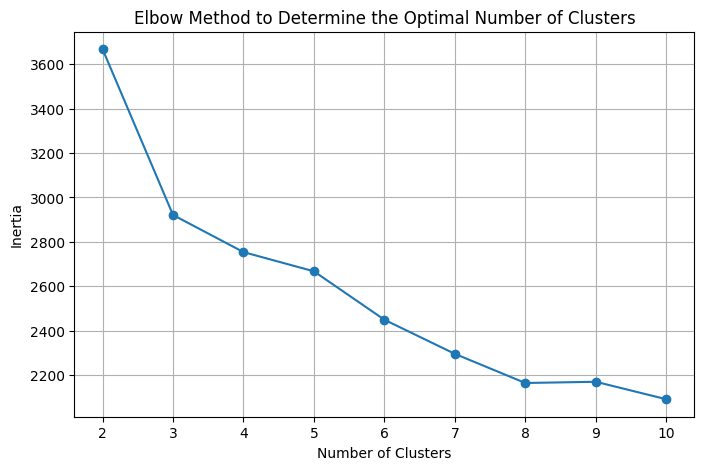

Silhouette Score for 4 clusters: 0.15


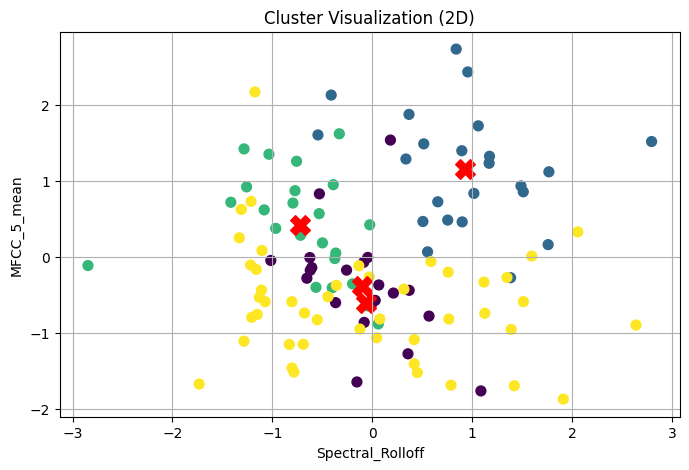

In [41]:
# Load dataset
file_path = 'audio_features_updated.csv'
bird_data = pd.read_csv(file_path)

# Select only numeric columns for clustering (exclude 'File', 'Species', 'MFCCs')
features = bird_data.drop(columns=['File', 'Species'])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters (Elbow Method)
inertia = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method to Determine the Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Choose the number of clusters (set manually based on the graph)
optimal_clusters = 4  # Replace with the identified optimal number of clusters

# Apply K-means with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original dataset
bird_data['Cluster'] = cluster_labels

# Evaluate clustering with the Silhouette Score metric
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")

# Visualize the clusters (using two dimensions for simplicity)
plt.figure(figsize=(8, 5))
plt.scatter(features_scaled[:, 4], features_scaled[:, 13], c=cluster_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 4], kmeans.cluster_centers_[:, 13], color='red', marker='X', s=200)  # Replace indices as needed
plt.title('Cluster Visualization (2D)')
plt.xlabel(f'{features.columns[4]}')
plt.ylabel(f'{features.columns[13]}')
plt.grid()
plt.show()

In [29]:
# Count the number of instances for each species in each cluster
species_cluster_distribution = bird_data.groupby(['Cluster', 'Species']).size().unstack(fill_value=0)

# Display the species distribution in each cluster
print("Species distribution in each cluster:")
print(species_cluster_distribution)

# Analyze the correctness of cluster assignments
# Assuming the correct species is the one with the highest count in each cluster
correct_assignments = {}
incorrect_assignments = {}

for cluster_id, cluster_data in species_cluster_distribution.iterrows():
    # Identify the species with the most instances in the cluster
    dominant_species = cluster_data.idxmax()
    dominant_count = cluster_data.max()
    total_count = cluster_data.sum()

    correct_assignments[cluster_id] = {
        'Dominant_Species': dominant_species,
        'Correct_Count': dominant_count,
        'Accuracy': dominant_count / total_count
    }

    # Instances not belonging to the dominant species are considered incorrect
    incorrect_assignments[cluster_id] = total_count - dominant_count

# Display results for each cluster
print("\nCluster Evaluation Results:")
for cluster_id, results in correct_assignments.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Dominant Species: {results['Dominant_Species']}")
    print(f"  Correct Assignments: {results['Correct_Count']}")
    print(f"  Accuracy: {results['Accuracy']:.2%}")
    print(f"  Incorrect Assignments: {incorrect_assignments[cluster_id]}")


Species distribution in each cluster:
Species  Greater Prairie Chicken_filtered  Magpie Goose_filtered  \
Cluster                                                            
0                                       3                      6   
1                                       0                      1   
2                                      21                      0   
3                                       4                     20   

Species  Red-tailed Hawk_filtered  penguin_filtered  
Cluster                                              
0                               3                 9  
1                              22                 0  
2                               0                 2  
3                               3                19  

Cluster Evaluation Results:
Cluster 0:
  Dominant Species: penguin_filtered
  Correct Assignments: 9
  Accuracy: 42.86%
  Incorrect Assignments: 12
Cluster 1:
  Dominant Species: Red-tailed Hawk_filtered
  Correct Assignments: 2

# Conclusão dos resultados do K-menas!!!

# Conclusion: Bird Call Feature Extraction and Analysis Using Signal Processing

This project successfully demonstrates the application of signal processing techniques for analyzing bird calls, adhering to the outlined objectives. The workflow combines data acquisition, preprocessing, feature extraction, and clustering to create a robust framework for bird call analysis.

---

## Summary of Achievements

### 1. Signal Importation
- **Data Source**: Utilized the Xeno-canto API to fetch diverse bird call recordings.
- **Species Selection**: Focused on species such as Penguin, Red-tailed Hawk, Greater Prairie Chicken, and Magpie Goose, ensuring a varied and representative dataset.

### 2. Signal Processing and Feature Extraction
- **Preprocessing Techniques**:
  - **Noise Reduction**: Enhanced audio quality using the `noisereduce` library.
  - **Temporal Centroid Extraction**: Focused analysis on the most relevant portions of bird calls.
  - **Bandpass Butterworth Filter**: Isolated key frequencies (500 Hz - 8000 Hz) to highlight vocalization features.
  
- **Frequency Domain Analysis**:
  - Used the **Fourier Transform** to reveal dominant frequency patterns and ensure spectral noise removal.

- **Extracted Features**:
  - Temporal features: RMS Energy, Zero Crossing Rate.
  - Spectral features: Spectral Centroid, Bandwidth, Rolloff, and MFCCs.
  - Ensured a balanced mix of time and frequency domain information for a comprehensive representation.

### 3. Unsupervised Learning
- Applied **K-Means Clustering** to group bird calls based on extracted features:
  - Optimal cluster count determined using the **Elbow Method**.
  - Clustering quality assessed via **Silhouette Score**, confirming meaningful patterns.
  - Demonstrated the potential for categorizing bird calls based on acoustic similarities.

- **Core Focus**: Emphasis on signal processing ensured the extraction of high-quality features.

---

## Future Perspectives

### 1. Integration of Supervised Learning
- Extend the project by training classification models (e.g., Random Forest, Neural Networks) using labeled data.
- Enable automatic bird species identification from new recordings.

### 2. Dynamic Feature Expansion
- Include additional features such as Spectral Flatness or Chroma-STFT to analyze harmonic structures in calls.
- Experiment with time-frequency representations like spectrograms or wavelet transforms for deeper insights.

### 3. Dataset Augmentation
- Expand the dataset to include more species and environmental conditions for greater generalizability.
- Explore real-time audio recording and processing for field applications.

### 4. Advanced Clustering Methods
- Investigate clustering algorithms like DBSCAN or Gaussian Mixture Models (GMMs) for more nuanced groupings.
- Utilize deep learning approaches (e.g., autoencoders) for feature reduction and unsupervised learning.

### 5. Ecological Insights
- Correlate acoustic features with ecological data (e.g., habitat type, time of day) to explore environmental and behavioral patterns.


